# House Prices - Advanced Regression Techniques

**Goal:**
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

**Metric:**
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

## Importing libraries

In [1]:
%pip install catboost
%pip install optuna

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Loading data

In [3]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [6]:
combined_df = pd.concat([train_df, test_df], axis=0)
combined_df.drop('Id',axis=1, inplace=True)
combined_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [7]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt    

In [8]:
combined_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


**Separate categorical and continous values**

In [9]:
combined_df.dtypes.value_counts()

object     43
int64      25
float64    12
Name: count, dtype: int64

## Preprocessing numerical data

In [10]:
combined_df_cont = combined_df.select_dtypes(include=['int64','float64'])
combined_df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   LotFrontage    2433 non-null   float64
 2   LotArea        2919 non-null   int64  
 3   OverallQual    2919 non-null   int64  
 4   OverallCond    2919 non-null   int64  
 5   YearBuilt      2919 non-null   int64  
 6   YearRemodAdd   2919 non-null   int64  
 7   MasVnrArea     2896 non-null   float64
 8   BsmtFinSF1     2918 non-null   float64
 9   BsmtFinSF2     2918 non-null   float64
 10  BsmtUnfSF      2918 non-null   float64
 11  TotalBsmtSF    2918 non-null   float64
 12  1stFlrSF       2919 non-null   int64  
 13  2ndFlrSF       2919 non-null   int64  
 14  LowQualFinSF   2919 non-null   int64  
 15  GrLivArea      2919 non-null   int64  
 16  BsmtFullBath   2917 non-null   float64
 17  BsmtHalfBath   2917 non-null   float64
 18  FullBath     

In [11]:
missing_list = combined_df_cont.isnull().sum()[combined_df_cont.isnull().sum() > 0].drop('SalePrice')
missing_list

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [12]:
for column_name in missing_list.index:
    null_rows = combined_df_cont[combined_df_cont[column_name].isnull()]
    null_value_percentage = len(null_rows) / len(combined_df_cont) * 100

    print(f"{null_value_percentage} % of '{column_name}' values are missing\n")

16.649537512846866 % of 'LotFrontage' values are missing

0.7879410757108599 % of 'MasVnrArea' values are missing

0.0342583076396026 % of 'BsmtFinSF1' values are missing

0.0342583076396026 % of 'BsmtFinSF2' values are missing

0.0342583076396026 % of 'BsmtUnfSF' values are missing

0.0342583076396026 % of 'TotalBsmtSF' values are missing

0.0685166152792052 % of 'BsmtFullBath' values are missing

0.0685166152792052 % of 'BsmtHalfBath' values are missing

5.4470709146968135 % of 'GarageYrBlt' values are missing

0.0342583076396026 % of 'GarageCars' values are missing

0.0342583076396026 % of 'GarageArea' values are missing



**a] I will fill missing values in 'LotFrontage' column**

I will check correlation of LotFrontage column to others

In [13]:
combined_df_cont.corr()['LotFrontage'].sort_values(ascending=False)

LotFrontage      1.000000
LotArea          0.489896
1stFlrSF         0.458247
GrLivArea        0.382462
GarageArea       0.359786
TotalBsmtSF      0.354822
SalePrice        0.351799
TotRmsAbvGrd     0.349513
GarageCars       0.310587
Fireplaces       0.261970
BedroomAbvGr     0.234892
MasVnrArea       0.221079
BsmtFinSF1       0.219408
OverallQual      0.217645
FullBath         0.181668
PoolArea         0.174119
OpenPorchSF      0.164896
YearBuilt        0.122811
WoodDeckSF       0.122070
BsmtUnfSF        0.113714
BsmtFullBath     0.113245
YearRemodAdd     0.091557
GarageYrBlt      0.076673
ScreenPorch      0.075858
BsmtFinSF2       0.047431
MiscVal          0.044272
HalfBath         0.039452
3SsnPorch        0.028289
2ndFlrSF         0.026545
EnclosedPorch    0.011509
MoSold           0.011254
LowQualFinSF     0.004894
KitchenAbvGr     0.004676
YrSold          -0.007917
BsmtHalfBath    -0.025629
OverallCond     -0.075508
MSSubClass      -0.417359
Name: LotFrontage, dtype: float64

There is a 0.48 correlation to 'LotArea'. I will fill missing in 'LotFrontage' based on Linear regression to this column.

In [14]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Train the model using the rows that have both 'LotArea' and 'LotFrontage' values
x_train = combined_df[combined_df['LotFrontage'].notnull()]['LotArea'].values.reshape(-1, 1)
y_train = combined_df[combined_df['LotFrontage'].notnull()]['LotFrontage'].values.reshape(-1, 1)
model.fit(x_train, y_train)

# Predict the missing values using the model
x_test = combined_df[combined_df['LotFrontage'].isnull()]['LotArea'].values.reshape(-1, 1)
y_pred = model.predict(x_test)

# Assign the predicted values to the correct rows in the dataframe
combined_df.loc[combined_df['LotFrontage'].isnull(), 'LotFrontage'] = y_pred

**b] I will fill missing values in 'GarageYrBlt'**

In [15]:
combined_df_cont.corr()['GarageYrBlt'].sort_values(ascending=False)

GarageYrBlt      1.000000
YearBuilt        0.834812
YearRemodAdd     0.652365
GarageCars       0.587712
OverallQual      0.571803
GarageArea       0.555836
FullBath         0.495688
SalePrice        0.486362
TotalBsmtSF      0.348408
GrLivArea        0.273411
1stFlrSF         0.260450
MasVnrArea       0.255112
OpenPorchSF      0.231639
HalfBath         0.225157
WoodDeckSF       0.222584
BsmtFinSF1       0.194270
BsmtUnfSF        0.171588
TotRmsAbvGrd     0.162684
BsmtFullBath     0.150492
Fireplaces       0.089651
MSSubClass       0.087898
2ndFlrSF         0.086094
LotFrontage      0.076673
MoSold           0.024017
3SsnPorch        0.020699
YrSold          -0.004543
LotArea         -0.008628
MiscVal         -0.009203
PoolArea        -0.014467
BedroomAbvGr    -0.045364
LowQualFinSF    -0.051781
BsmtHalfBath    -0.058379
ScreenPorch     -0.062320
BsmtFinSF2      -0.068549
KitchenAbvGr    -0.092989
EnclosedPorch   -0.300751
OverallCond     -0.325849
Name: GarageYrBlt, dtype: float64

In [16]:
combined_df_cont[['GarageYrBlt', 'YearBuilt', 'YearRemodAdd']].head(5)

,GarageYrBlt,YearBuilt,YearRemodAdd
0,2003.0,2003,2003
1,1976.0,1976,1976
2,2001.0,2001,2002
3,1998.0,1915,1970
4,2000.0,2000,2000


'GarageYrBlt has a very strong correlation to 'YearBuilt'. It is usually the same value. I will fill missing values with the same value as in 'YearBuilt' column.

In [17]:
combined_df['GarageYrBlt']= combined_df['GarageYrBlt'].combine_first(combined_df['YearBuilt'])

**c] I will fill remaining missing data with column´s mean.%**

In [18]:
combined_df_cont = combined_df.select_dtypes(include=['int64','float64'])
missing_list = combined_df_cont.isnull().sum()[combined_df_cont.isnull().sum() > 0].drop('SalePrice')
missing_list

MasVnrArea      23
BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
GarageCars       1
GarageArea       1
dtype: int64

In [19]:
for column in missing_list.index:
    combined_df[column].fillna(combined_df[column].mean(), inplace=True)

In [20]:
combined_df_cont = combined_df.select_dtypes(include=['int64','float64'])
combined_df_cont.isnull().sum()

MSSubClass          0
LotFrontage         0
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea          0
BsmtFinSF1          0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt         0
GarageCars          0
GarageArea          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
dtype: int64

Now there are no missing values in the continous columns.

**Distributions of numerical data**

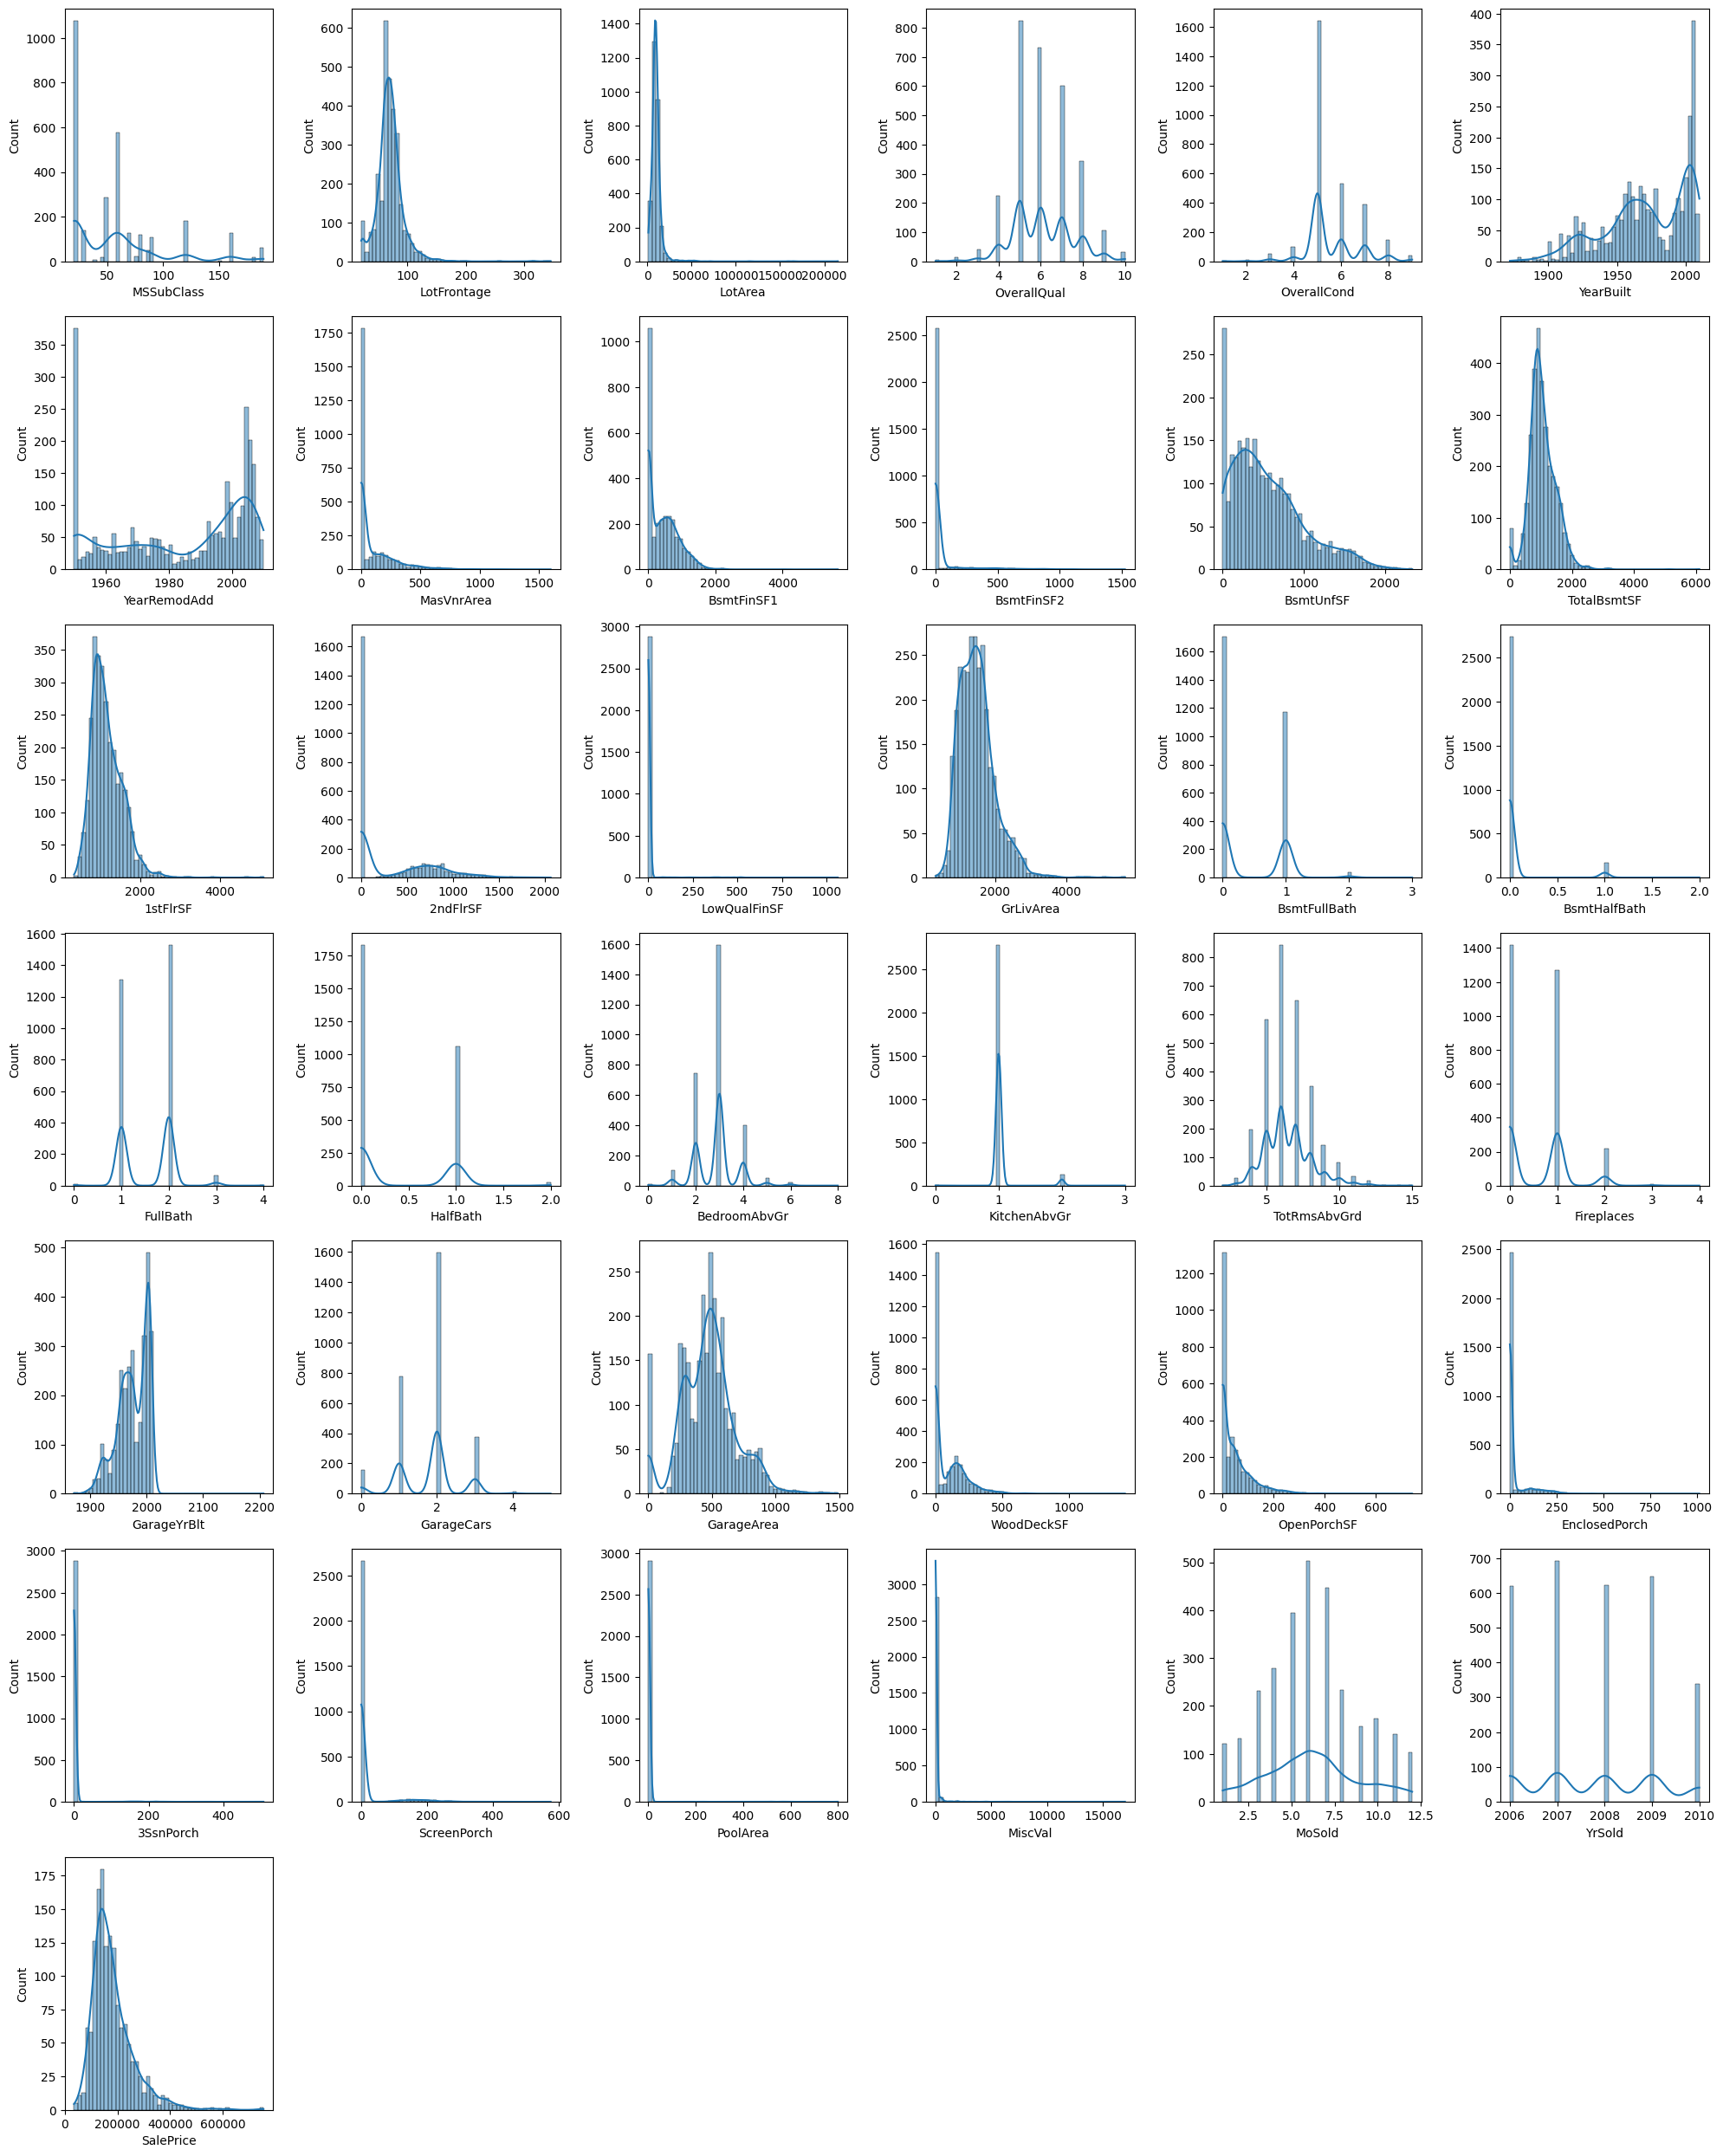

In [21]:

plt.figure(figsize=(20,25))
for col in range(0, len(combined_df_cont.columns)):
    plt.subplot(7,6,col+1)
    sns.histplot(combined_df_cont.iloc[:, col],bins=50, kde=True)

plt.tight_layout()

## Preprocessing the categorical data

In [22]:
combined_df_cat = combined_df.drop(columns=combined_df_cont.columns)

In [23]:
combined_df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       2915 non-null   object
 1   Street         2919 non-null   object
 2   Alley          198 non-null    object
 3   LotShape       2919 non-null   object
 4   LandContour    2919 non-null   object
 5   Utilities      2917 non-null   object
 6   LotConfig      2919 non-null   object
 7   LandSlope      2919 non-null   object
 8   Neighborhood   2919 non-null   object
 9   Condition1     2919 non-null   object
 10  Condition2     2919 non-null   object
 11  BldgType       2919 non-null   object
 12  HouseStyle     2919 non-null   object
 13  RoofStyle      2919 non-null   object
 14  RoofMatl       2919 non-null   object
 15  Exterior1st    2918 non-null   object
 16  Exterior2nd    2918 non-null   object
 17  MasVnrType     1153 non-null   object
 18  ExterQual      2919 non-null   ob

In [24]:
missing_list_cat = combined_df_cat.isnull().sum()[combined_df_cat.isnull().sum() > 0]
missing_list_cat

MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [25]:
for column_name in missing_list_cat.index:
    null_rows = combined_df_cat[combined_df_cat[column_name].isnull()]
    null_value_percentage = len(null_rows) / len(combined_df_cat) * 100

    print(f"{null_value_percentage} % of '{column_name}' values are missing\n")

0.1370332305584104 % of 'MSZoning' values are missing

93.21685508735868 % of 'Alley' values are missing

0.0685166152792052 % of 'Utilities' values are missing

0.0342583076396026 % of 'Exterior1st' values are missing

0.0342583076396026 % of 'Exterior2nd' values are missing

60.500171291538194 % of 'MasVnrType' values are missing

2.774922918807811 % of 'BsmtQual' values are missing

2.8091812264474134 % of 'BsmtCond' values are missing

2.8091812264474134 % of 'BsmtExposure' values are missing

2.7064063035286057 % of 'BsmtFinType1' values are missing

2.7406646111682083 % of 'BsmtFinType2' values are missing

0.0342583076396026 % of 'Electrical' values are missing

0.0342583076396026 % of 'KitchenQual' values are missing

0.0685166152792052 % of 'Functional' values are missing

48.646796848235695 % of 'FireplaceQu' values are missing

5.378554299417608 % of 'GarageType' values are missing

5.4470709146968135 % of 'GarageFinish' values are missing

5.4470709146968135 % of 'GarageQua

**a] Fill missing values in these columns 'Alley','FireplaceQu','PoolQC','Fence','MiscFeature'\
    with a new string "0" since these are not in the builing.**

In [26]:
columns_not_aval = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']

In [27]:
combined_df[columns_not_aval] = combined_df[columns_not_aval].fillna('0')

**b] Deal with the missing values regarding to Basement**

In [28]:
basement_columns = ['BsmtQual','BsmtCond','BsmtExposure', 'BsmtFinType1','BsmtFinType2' ]

In [29]:
combined_df[basement_columns] = combined_df[basement_columns].fillna('0')

**c] Deal with the missing values regarding to Garage**

In [30]:
garage_columns = ['GarageType','GarageFinish','GarageQual', 'GarageCond']

In [31]:
combined_df[garage_columns] = combined_df[garage_columns].fillna('0')

**d] I will fill the median value in missing values.**

In [32]:
combined_df_cat = combined_df.drop(columns=combined_df_cont.columns)
missing_list_cat = combined_df_cat.isnull().sum()[combined_df_cat.isnull().sum() > 0]
missing_list_cat

MSZoning          4
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType     1766
Electrical        1
KitchenQual       1
Functional        2
SaleType          1
dtype: int64

In [33]:
for column in missing_list_cat.index:

    most_common_value = combined_df[column].value_counts().idxmax()
    
    combined_df[column].fillna(most_common_value, inplace=True)

In [34]:
combined_df_cat = combined_df.drop(columns=combined_df_cont.columns)
combined_df_cat.isnull().sum()

MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
dtype: int64

Now there are no missing values in the categorical columns.

**Distribution of categorical columns data**

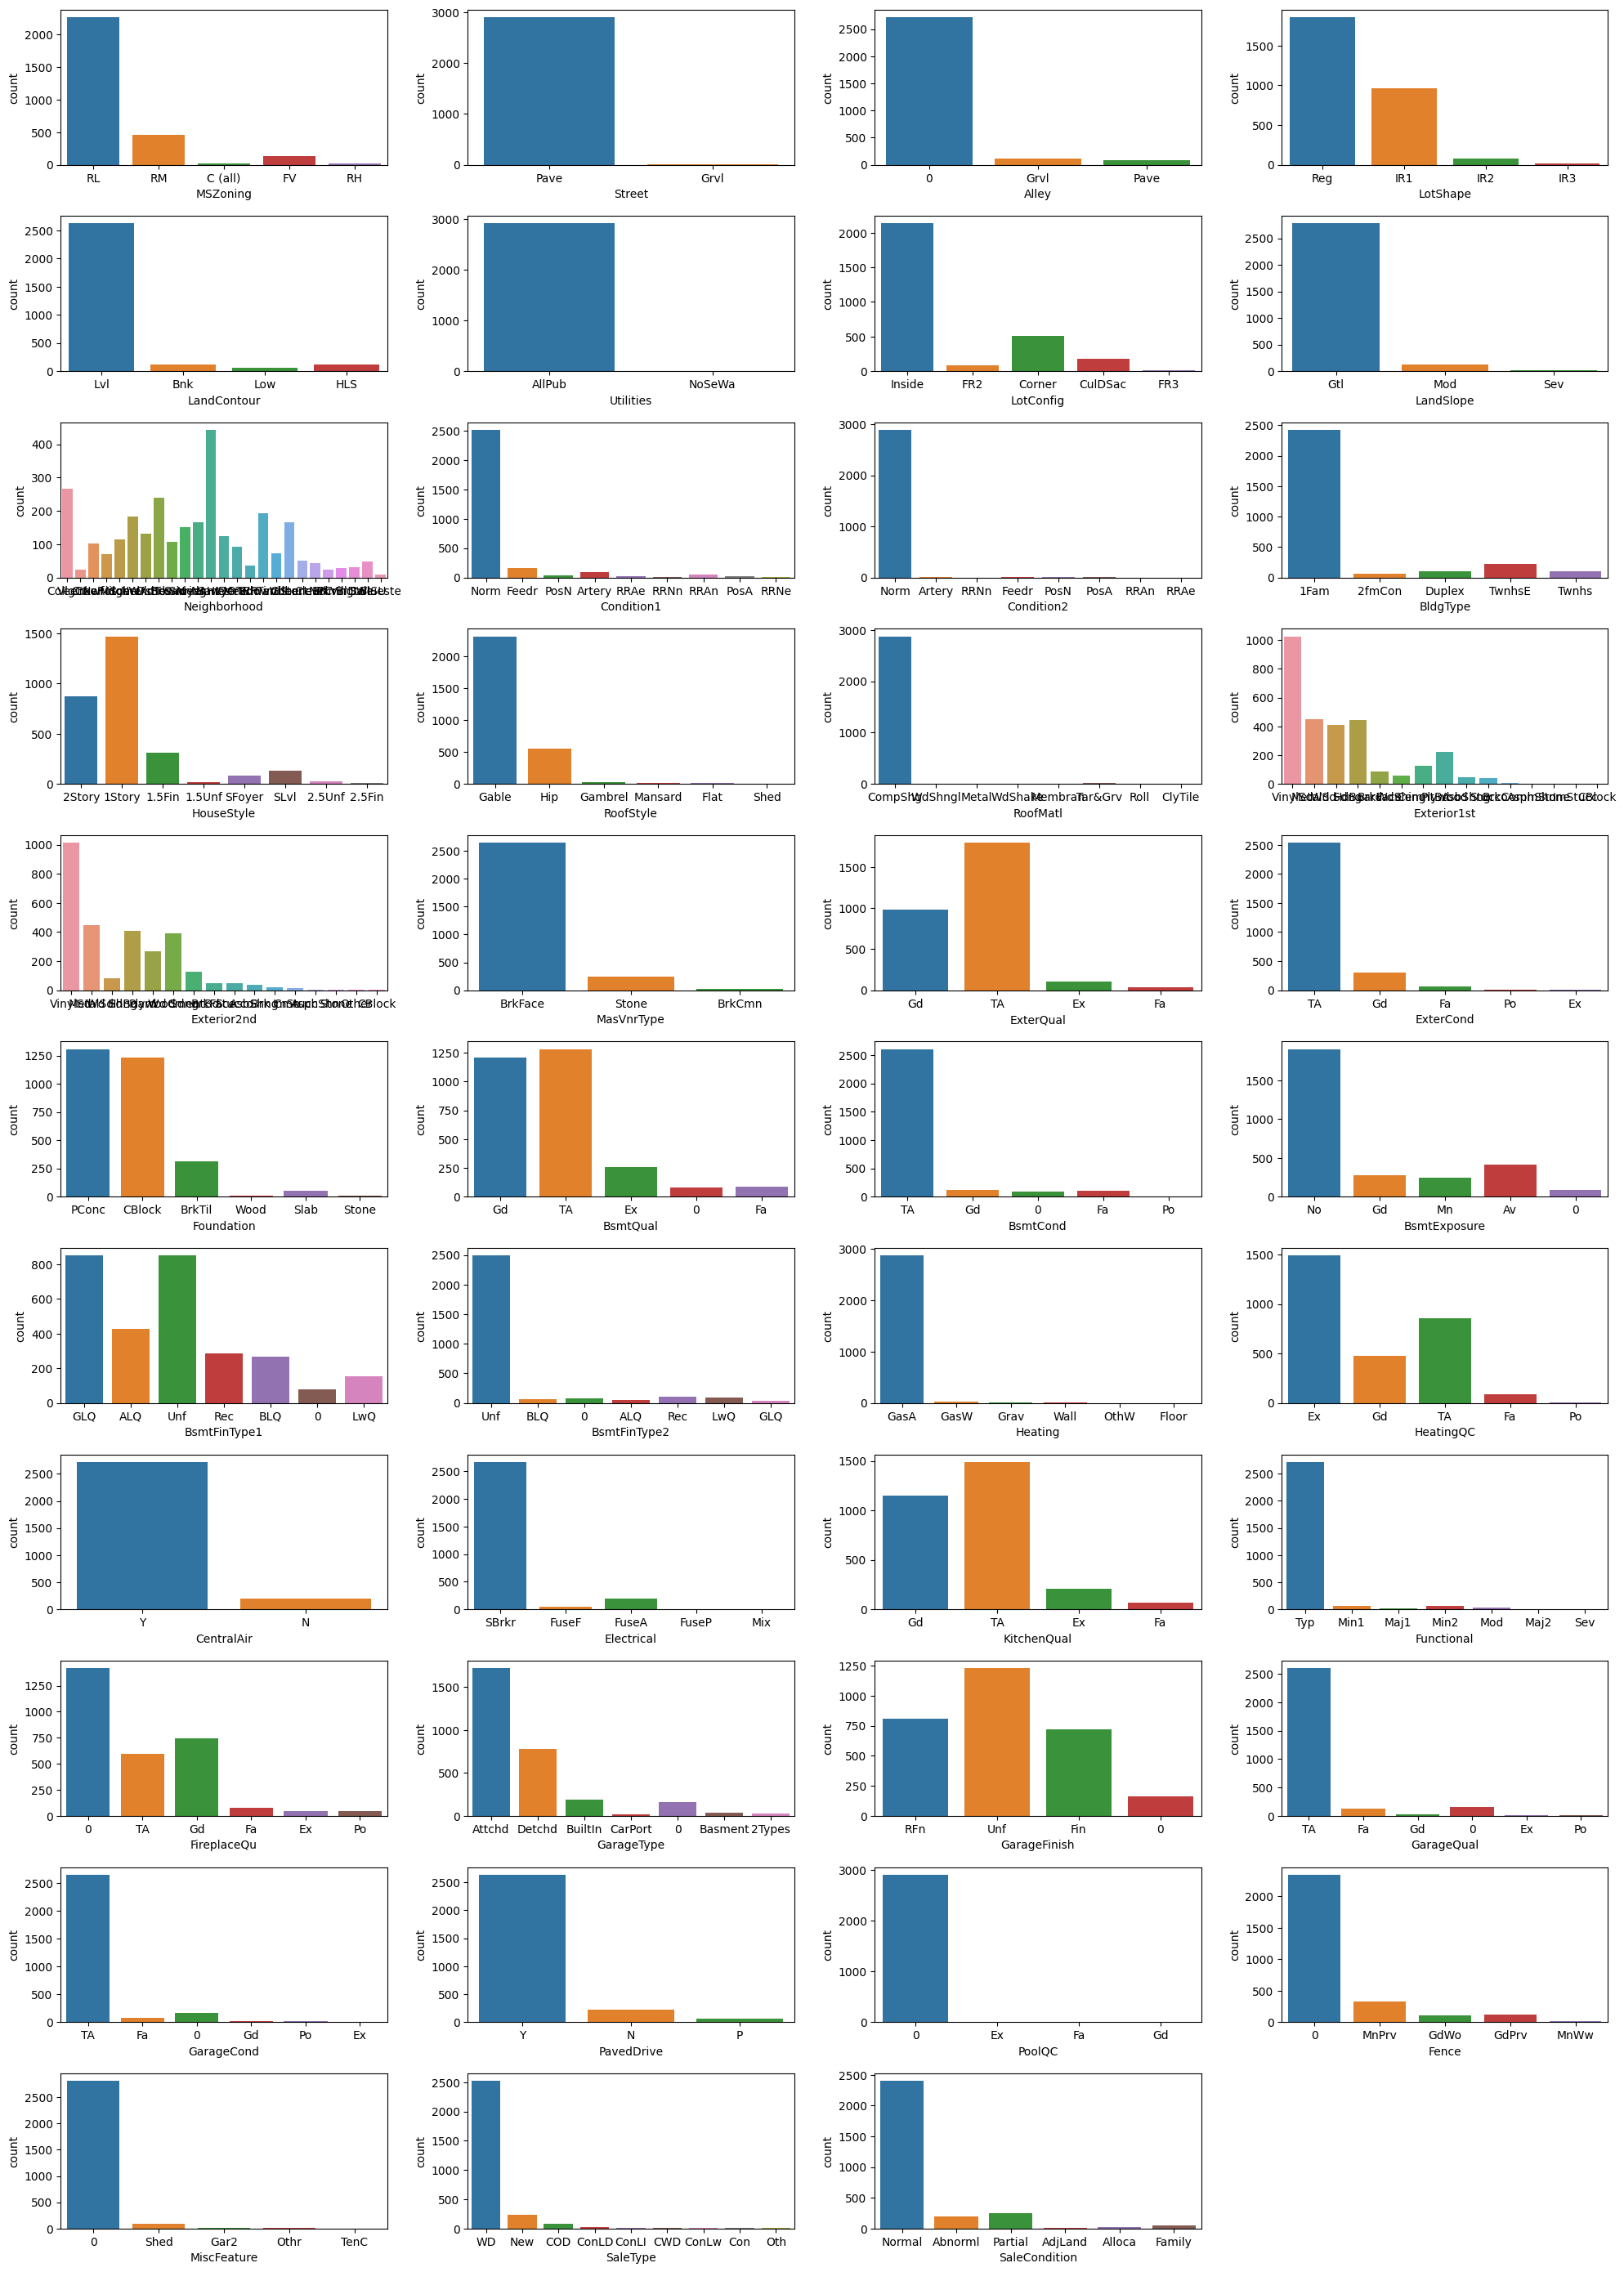

In [35]:
plt.figure(figsize=(20, 30))

for col in range(0, len(combined_df_cat.columns)):
    plt.subplot(12, 4, col+1)
    sns.countplot(x=combined_df_cat.columns[col], data=combined_df_cat)

plt.tight_layout()

## Encoding the categorical data

No need to encode categorical data, as CatBoost can process them anyway.

In [36]:
#label_encoded_columns =['Alley', 'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'HouseStyle', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', ]

In [37]:
#label_encoded_columns_set = set(label_encoded_columns)
#combined_df_cat_columns_set = set(combined_df_cat.columns)

#one_hot_encoded_columns = combined_df_cat_columns_set - label_encoded_columns_set

## Feature Engineering

a] Feature total number of bathrooms

In [38]:
combined_df['Bathrooms'] = combined_df['BsmtFullBath']+combined_df['FullBath']+0.5*combined_df['BsmtHalfBath']+0.5*combined_df['HalfBath']

b] Total square feet of building

In [39]:
combined_df['BuildingSF'] = combined_df['TotalBsmtSF']+combined_df['1stFlrSF']+ combined_df['2ndFlrSF']

c] Total square feet of porch

In [40]:
combined_df['TotalPorch'] = combined_df['WoodDeckSF']+combined_df['OpenPorchSF']+combined_df['EnclosedPorch']+combined_df['3SsnPorch']+combined_df['ScreenPorch']

## Splitting the data

In [41]:
train_df = combined_df[combined_df['SalePrice'].notnull()]
X = train_df.drop('SalePrice',axis=1)
y = train_df['SalePrice']

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2, random_state=42)

In [43]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1168, 82)
(292, 82)
(1168,)
(292,)


## Creating a CatBoost Model & Hyperparameter tuning

CatBoost hyperparameter tuning with Optuna\
https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/

In [44]:
# Select non-encoded categorical data to be fed into the model
cat_features = combined_df_cat.columns.tolist()

In [45]:
def objective(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    
    cbr_model = CatBoostRegressor(**params, random_state=42)

    cbr_model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  cat_features=cat_features)
    rmse = np.sqrt(mean_squared_error(y_val, cbr_model.predict(X_val)))
    return rmse

In [46]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-01-19 09:11:49,274] A new study created in memory with name: no-name-1a495b0a-e648-49b2-ae57-d38f24caa101


0:	learn: 75218.4299709	test: 85576.2941121	best: 85576.2941121 (0)	total: 95.4ms	remaining: 19s
1:	learn: 73465.0680186	test: 83915.1878986	best: 83915.1878986 (1)	total: 134ms	remaining: 13.2s
2:	learn: 71604.8168218	test: 82029.8074095	best: 82029.8074095 (2)	total: 182ms	remaining: 11.9s
3:	learn: 69740.0443649	test: 80079.0427006	best: 80079.0427006 (3)	total: 241ms	remaining: 11.8s
4:	learn: 68115.8260170	test: 78311.6031077	best: 78311.6031077 (4)	total: 288ms	remaining: 11.2s
5:	learn: 66562.5253797	test: 76666.8349337	best: 76666.8349337 (5)	total: 329ms	remaining: 10.6s
6:	learn: 64940.8461300	test: 74989.8889283	best: 74989.8889283 (6)	total: 365ms	remaining: 10.1s
7:	learn: 63400.1492846	test: 73295.5752538	best: 73295.5752538 (7)	total: 405ms	remaining: 9.71s
8:	learn: 61932.4710780	test: 71716.1824090	best: 71716.1824090 (8)	total: 437ms	remaining: 9.28s
9:	learn: 60366.5775485	test: 69969.2892207	best: 69969.2892207 (9)	total: 475ms	remaining: 9.02s
10:	learn: 59071.0652

[I 2024-01-19 09:11:57,620] Trial 0 finished with value: 27868.718607127084 and parameters: {'learning_rate': 0.042165587993786044, 'depth': 7, 'subsample': 0.7918973756781071, 'colsample_bylevel': 0.8739207602023791, 'min_data_in_leaf': 88}. Best is trial 0 with value: 27868.718607127084.


198:	learn: 15973.7827292	test: 27908.1715158	best: 27908.1715158 (198)	total: 7.99s	remaining: 40.1ms
199:	learn: 15911.6063038	test: 27868.7186071	best: 27868.7186071 (199)	total: 8.03s	remaining: 0us

bestTest = 27868.71861
bestIteration = 199

0:	learn: 76683.5045767	test: 87043.6627819	best: 87043.6627819 (0)	total: 4.78ms	remaining: 952ms
1:	learn: 76084.2232901	test: 86413.8797302	best: 86413.8797302 (1)	total: 9.36ms	remaining: 927ms
2:	learn: 75537.8533553	test: 85832.9041589	best: 85832.9041589 (2)	total: 14.1ms	remaining: 928ms
3:	learn: 74979.8007819	test: 85267.6906780	best: 85267.6906780 (3)	total: 18.5ms	remaining: 906ms
4:	learn: 74394.8075011	test: 84654.2073171	best: 84654.2073171 (4)	total: 23.1ms	remaining: 901ms
5:	learn: 73815.0347006	test: 84076.5349027	best: 84076.5349027 (5)	total: 27.5ms	remaining: 891ms
6:	learn: 73292.0031351	test: 83526.1415142	best: 83526.1415142 (6)	total: 31.8ms	remaining: 877ms
7:	learn: 72774.3914061	test: 82966.9736482	best: 82966.973

[I 2024-01-19 09:11:58,519] Trial 1 finished with value: 38993.83409449091 and parameters: {'learning_rate': 0.012469906310192217, 'depth': 4, 'subsample': 0.5332012300892417, 'colsample_bylevel': 0.2902009536771715, 'min_data_in_leaf': 96}. Best is trial 0 with value: 27868.718607127084.


164:	learn: 34333.5565550	test: 41754.5540982	best: 41754.5540982 (164)	total: 652ms	remaining: 138ms
165:	learn: 34226.7669180	test: 41624.6349713	best: 41624.6349713 (165)	total: 658ms	remaining: 135ms
166:	learn: 34146.1106768	test: 41539.6896271	best: 41539.6896271 (166)	total: 662ms	remaining: 131ms
167:	learn: 34079.9719416	test: 41461.9800931	best: 41461.9800931 (167)	total: 666ms	remaining: 127ms
168:	learn: 33989.2184340	test: 41355.2696807	best: 41355.2696807 (168)	total: 669ms	remaining: 123ms
169:	learn: 33893.5196179	test: 41256.8143459	best: 41256.8143459 (169)	total: 673ms	remaining: 119ms
170:	learn: 33809.6420091	test: 41140.5096520	best: 41140.5096520 (170)	total: 676ms	remaining: 115ms
171:	learn: 33705.8037797	test: 41077.6180388	best: 41077.6180388 (171)	total: 680ms	remaining: 111ms
172:	learn: 33634.6396047	test: 41013.2443440	best: 41013.2443440 (172)	total: 684ms	remaining: 107ms
173:	learn: 33559.7732449	test: 40924.9407166	best: 40924.9407166 (173)	total: 688

[I 2024-01-19 09:12:02,163] Trial 2 finished with value: 31877.955359745312 and parameters: {'learning_rate': 0.024649170626793872, 'depth': 6, 'subsample': 0.14594778660076257, 'colsample_bylevel': 0.8118252451621221, 'min_data_in_leaf': 17}. Best is trial 0 with value: 27868.718607127084.


0:	learn: 76959.2683577	test: 87351.3828944	best: 87351.3828944 (0)	total: 6.52ms	remaining: 1.3s
1:	learn: 76686.5629154	test: 87070.9883747	best: 87070.9883747 (1)	total: 13.9ms	remaining: 1.37s
2:	learn: 76435.0739183	test: 86818.8270405	best: 86818.8270405 (2)	total: 19.7ms	remaining: 1.29s
3:	learn: 76158.7656418	test: 86536.1066510	best: 86536.1066510 (3)	total: 24.8ms	remaining: 1.22s
4:	learn: 75915.5737865	test: 86288.3666505	best: 86288.3666505 (4)	total: 30.3ms	remaining: 1.18s
5:	learn: 75659.9083452	test: 86017.6462425	best: 86017.6462425 (5)	total: 36.7ms	remaining: 1.19s
6:	learn: 75396.3314975	test: 85752.9315482	best: 85752.9315482 (6)	total: 41.8ms	remaining: 1.15s
7:	learn: 75154.1024307	test: 85505.7912188	best: 85505.7912188 (7)	total: 47.7ms	remaining: 1.15s
8:	learn: 74908.1434685	test: 85243.1554152	best: 85243.1554152 (8)	total: 54.3ms	remaining: 1.15s
9:	learn: 74661.2246198	test: 84984.8612117	best: 84984.8612117 (9)	total: 60.3ms	remaining: 1.15s
10:	learn: 

[I 2024-01-19 09:12:03,480] Trial 3 finished with value: 53482.92019987137 and parameters: {'learning_rate': 0.005449776772848927, 'depth': 5, 'subsample': 0.15017903577229474, 'colsample_bylevel': 0.3844547783211026, 'min_data_in_leaf': 19}. Best is trial 0 with value: 27868.718607127084.


198:	learn: 45018.2185250	test: 53595.8959383	best: 53595.8959383 (198)	total: 1.2s	remaining: 6.01ms
199:	learn: 44918.7858465	test: 53482.9201999	best: 53482.9201999 (199)	total: 1.2s	remaining: 0us

bestTest = 53482.9202
bestIteration = 199

0:	learn: 76752.7031011	test: 87152.9147970	best: 87152.9147970 (0)	total: 17.2ms	remaining: 3.43s
1:	learn: 76270.5414980	test: 86631.4192415	best: 86631.4192415 (1)	total: 30.6ms	remaining: 3.02s
2:	learn: 75836.2143587	test: 86207.8618808	best: 86207.8618808 (2)	total: 45.4ms	remaining: 2.98s
3:	learn: 75374.8095236	test: 85717.1018479	best: 85717.1018479 (3)	total: 57.3ms	remaining: 2.81s
4:	learn: 74963.4622562	test: 85288.1961503	best: 85288.1961503 (4)	total: 70.4ms	remaining: 2.75s
5:	learn: 74541.7772374	test: 84848.5819374	best: 84848.5819374 (5)	total: 84.8ms	remaining: 2.74s
6:	learn: 74080.1023620	test: 84361.8996118	best: 84361.8996118 (6)	total: 95.2ms	remaining: 2.63s
7:	learn: 73644.9584609	test: 83913.2900554	best: 83913.290055

[I 2024-01-19 09:12:06,257] Trial 4 finished with value: 42052.21217396286 and parameters: {'learning_rate': 0.010145539790811129, 'depth': 8, 'subsample': 0.29888400396180365, 'colsample_bylevel': 0.11971047444549135, 'min_data_in_leaf': 97}. Best is trial 0 with value: 27868.718607127084.


196:	learn: 33067.6127258	test: 42287.6188641	best: 42287.6188641 (196)	total: 2.6s	remaining: 39.6ms
197:	learn: 32986.0638703	test: 42216.3572054	best: 42216.3572054 (197)	total: 2.62s	remaining: 26.4ms
198:	learn: 32909.3805227	test: 42152.1533409	best: 42152.1533409 (198)	total: 2.63s	remaining: 13.2ms
199:	learn: 32811.7969760	test: 42052.2121740	best: 42052.2121740 (199)	total: 2.65s	remaining: 0us

bestTest = 42052.21217
bestIteration = 199

0:	learn: 77000.4606442	test: 87374.8492884	best: 87374.8492884 (0)	total: 15.3ms	remaining: 3.04s
1:	learn: 76758.9299819	test: 87114.3245263	best: 87114.3245263 (1)	total: 28.9ms	remaining: 2.87s
2:	learn: 76511.4861602	test: 86848.4484077	best: 86848.4484077 (2)	total: 42.2ms	remaining: 2.77s
3:	learn: 76286.1624059	test: 86600.2348539	best: 86600.2348539 (3)	total: 54.6ms	remaining: 2.67s
4:	learn: 76065.3859555	test: 86355.1891727	best: 86355.1891727 (4)	total: 71ms	remaining: 2.77s
5:	learn: 75816.7909962	test: 86084.7178961	best: 8608

[I 2024-01-19 09:12:09,368] Trial 5 finished with value: 54734.6381468257 and parameters: {'learning_rate': 0.004833844159454451, 'depth': 6, 'subsample': 0.531531279687206, 'colsample_bylevel': 0.6371196297875327, 'min_data_in_leaf': 82}. Best is trial 0 with value: 27868.718607127084.


199:	learn: 45946.8967817	test: 54734.6381468	best: 54734.6381468 (199)	total: 2.99s	remaining: 0us

bestTest = 54734.63815
bestIteration = 199

0:	learn: 75543.7889085	test: 85841.1654169	best: 85841.1654169 (0)	total: 11.6ms	remaining: 2.31s
1:	learn: 73977.4046275	test: 84184.2221881	best: 84184.2221881 (1)	total: 22.7ms	remaining: 2.25s
2:	learn: 72480.0004762	test: 82552.4292313	best: 82552.4292313 (2)	total: 35ms	remaining: 2.3s
3:	learn: 71003.1279280	test: 80941.3826867	best: 80941.3826867 (3)	total: 46ms	remaining: 2.25s
4:	learn: 69677.1003827	test: 79473.8899407	best: 79473.8899407 (4)	total: 56.3ms	remaining: 2.2s
5:	learn: 68301.8755870	test: 78039.6954501	best: 78039.6954501 (5)	total: 67.7ms	remaining: 2.19s
6:	learn: 66956.8000561	test: 76597.1032666	best: 76597.1032666 (6)	total: 79.6ms	remaining: 2.19s
7:	learn: 65676.2111598	test: 75250.2036213	best: 75250.2036213 (7)	total: 90.6ms	remaining: 2.17s
8:	learn: 64359.3065163	test: 73862.7679131	best: 73862.7679131 (8)	t

[I 2024-01-19 09:12:11,719] Trial 6 finished with value: 28152.35223999531 and parameters: {'learning_rate': 0.03274029507686305, 'depth': 5, 'subsample': 0.6447616063227262, 'colsample_bylevel': 0.7300797986176373, 'min_data_in_leaf': 52}. Best is trial 0 with value: 27868.718607127084.


193:	learn: 20402.3483011	test: 28231.8189382	best: 28231.8189382 (193)	total: 2.16s	remaining: 66.9ms
194:	learn: 20380.0746618	test: 28224.1227658	best: 28224.1227658 (194)	total: 2.17s	remaining: 55.8ms
195:	learn: 20356.3538693	test: 28218.9574289	best: 28218.9574289 (195)	total: 2.19s	remaining: 44.6ms
196:	learn: 20338.5702895	test: 28192.6966392	best: 28192.6966392 (196)	total: 2.19s	remaining: 33.4ms
197:	learn: 20279.2268453	test: 28152.3522400	best: 28152.3522400 (197)	total: 2.21s	remaining: 22.3ms
198:	learn: 20229.9064735	test: 28166.5206173	best: 28152.3522400 (197)	total: 2.22s	remaining: 11.2ms
199:	learn: 20198.2909323	test: 28163.0911615	best: 28152.3522400 (197)	total: 2.23s	remaining: 0us

bestTest = 28152.35224
bestIteration = 197

Shrink model to first 198 iterations.
0:	learn: 73943.4265098	test: 83963.5447868	best: 83963.5447868 (0)	total: 7.61ms	remaining: 1.51s
1:	learn: 70933.9533582	test: 80739.3989013	best: 80739.3989013 (1)	total: 14.3ms	remaining: 1.42s
2

[I 2024-01-19 09:12:13,204] Trial 7 finished with value: 27864.031077783337 and parameters: {'learning_rate': 0.061834682760391196, 'depth': 5, 'subsample': 0.9887810458505059, 'colsample_bylevel': 0.3409021678645356, 'min_data_in_leaf': 32}. Best is trial 7 with value: 27864.031077783337.


184:	learn: 16467.0287487	test: 28127.3141691	best: 28127.3141691 (184)	total: 1.26s	remaining: 102ms
185:	learn: 16432.6613809	test: 28104.1354801	best: 28104.1354801 (185)	total: 1.26s	remaining: 95.2ms
186:	learn: 16390.0746635	test: 28082.3931553	best: 28082.3931553 (186)	total: 1.27s	remaining: 88.5ms
187:	learn: 16330.6956339	test: 28034.1801028	best: 28034.1801028 (187)	total: 1.28s	remaining: 81.6ms
188:	learn: 16300.4006376	test: 28019.3162545	best: 28019.3162545 (188)	total: 1.29s	remaining: 74.9ms
189:	learn: 16252.3706039	test: 28009.4582560	best: 28009.4582560 (189)	total: 1.29s	remaining: 68.1ms
190:	learn: 16214.1067633	test: 27995.7604642	best: 27995.7604642 (190)	total: 1.3s	remaining: 61.3ms
191:	learn: 16179.6143692	test: 27970.2917588	best: 27970.2917588 (191)	total: 1.31s	remaining: 54.5ms
192:	learn: 16131.0824858	test: 27946.4676189	best: 27946.4676189 (192)	total: 1.31s	remaining: 47.7ms
193:	learn: 16116.6268591	test: 27944.1898507	best: 27944.1898507 (193)	tot

[I 2024-01-19 09:12:20,750] Trial 8 finished with value: 30724.45501545084 and parameters: {'learning_rate': 0.031140537567883073, 'depth': 10, 'subsample': 0.27469872820913754, 'colsample_bylevel': 0.33246150036230104, 'min_data_in_leaf': 15}. Best is trial 7 with value: 27864.031077783337.


197:	learn: 15869.1166759	test: 30771.1573794	best: 30771.1573794 (197)	total: 7.31s	remaining: 73.9ms
198:	learn: 15822.4371482	test: 30754.1111859	best: 30754.1111859 (198)	total: 7.35s	remaining: 37ms
199:	learn: 15775.1210201	test: 30724.4550155	best: 30724.4550155 (199)	total: 7.4s	remaining: 0us

bestTest = 30724.45502
bestIteration = 199

0:	learn: 77158.8703116	test: 87542.3734515	best: 87542.3734515 (0)	total: 9.83ms	remaining: 1.96s
1:	learn: 77091.7495323	test: 87469.2423782	best: 87469.2423782 (1)	total: 20.2ms	remaining: 2s
2:	learn: 77022.3652021	test: 87395.5719751	best: 87395.5719751 (2)	total: 29.9ms	remaining: 1.96s
3:	learn: 76955.2577359	test: 87330.3034063	best: 87330.3034063 (3)	total: 38.9ms	remaining: 1.91s
4:	learn: 76886.4742026	test: 87253.7819926	best: 87253.7819926 (4)	total: 48.6ms	remaining: 1.89s
5:	learn: 76821.0578139	test: 87186.2762784	best: 87186.2762784 (5)	total: 58.1ms	remaining: 1.88s
6:	learn: 76763.0928091	test: 87127.2994935	best: 87127.29949

[I 2024-01-19 09:12:22,707] Trial 9 finished with value: 75263.18425900185 and parameters: {'learning_rate': 0.0014056315300862957, 'depth': 4, 'subsample': 0.587668335145568, 'colsample_bylevel': 0.9535444585844807, 'min_data_in_leaf': 21}. Best is trial 7 with value: 27864.031077783337.


199:	learn: 65393.8129146	test: 75263.1842590	best: 75263.1842590 (199)	total: 1.84s	remaining: 0us

bestTest = 75263.18426
bestIteration = 199

0:	learn: 76924.4692428	test: 87254.1303626	best: 87254.1303626 (0)	total: 687us	remaining: 137ms
1:	learn: 75566.9369540	test: 86130.6562796	best: 86130.6562796 (1)	total: 1.41ms	remaining: 140ms
2:	learn: 74754.2860545	test: 85303.4842114	best: 85303.4842114 (2)	total: 2.1ms	remaining: 138ms
3:	learn: 73811.8613213	test: 84146.2072051	best: 84146.2072051 (3)	total: 2.5ms	remaining: 123ms
4:	learn: 72702.5029186	test: 83229.7570055	best: 83229.7570055 (4)	total: 3.13ms	remaining: 122ms
5:	learn: 72363.0795583	test: 82937.8908373	best: 82937.8908373 (5)	total: 3.61ms	remaining: 117ms
6:	learn: 71151.5510923	test: 81594.5501448	best: 81594.5501448 (6)	total: 4.1ms	remaining: 113ms
7:	learn: 69778.2334274	test: 80251.6700903	best: 80251.6700903 (7)	total: 4.51ms	remaining: 108ms
8:	learn: 69377.3408425	test: 80027.3931735	best: 80027.3931735 (8)

[I 2024-01-19 09:12:22,932] Trial 10 finished with value: 31549.138084165126 and parameters: {'learning_rate': 0.09481609646434831, 'depth': 1, 'subsample': 0.9865874178457391, 'colsample_bylevel': 0.059932497594257506, 'min_data_in_leaf': 46}. Best is trial 7 with value: 27864.031077783337.


161:	learn: 28687.4715111	test: 32865.9238296	best: 32865.9238296 (161)	total: 78.2ms	remaining: 18.3ms
162:	learn: 28643.8721404	test: 32826.4695286	best: 32826.4695286 (162)	total: 78.8ms	remaining: 17.9ms
163:	learn: 28610.0548936	test: 32775.8918268	best: 32775.8918268 (163)	total: 79.3ms	remaining: 17.4ms
164:	learn: 28571.8752880	test: 32773.7686377	best: 32773.7686377 (164)	total: 79.8ms	remaining: 16.9ms
165:	learn: 28559.3811153	test: 32745.6552201	best: 32745.6552201 (165)	total: 80.3ms	remaining: 16.5ms
166:	learn: 28531.4989846	test: 32732.3949060	best: 32732.3949060 (166)	total: 80.8ms	remaining: 16ms
167:	learn: 28473.0410757	test: 32577.1961716	best: 32577.1961716 (167)	total: 81.4ms	remaining: 15.5ms
168:	learn: 28471.0724514	test: 32577.2165212	best: 32577.1961716 (167)	total: 81.8ms	remaining: 15ms
169:	learn: 28408.5654706	test: 32440.0297541	best: 32440.0297541 (169)	total: 82.4ms	remaining: 14.5ms
170:	learn: 28366.5091632	test: 32373.7916662	best: 32373.7916662 (1

[I 2024-01-19 09:12:38,305] Trial 11 finished with value: 28230.325057515336 and parameters: {'learning_rate': 0.0897877707703083, 'depth': 8, 'subsample': 0.9899097876085109, 'colsample_bylevel': 0.9649321709432382, 'min_data_in_leaf': 49}. Best is trial 7 with value: 27864.031077783337.


199:	learn: 9653.5704880	test: 28230.3250575	best: 28230.3250575 (199)	total: 15.2s	remaining: 0us

bestTest = 28230.32506
bestIteration = 199

0:	learn: 75300.6861672	test: 85540.8363498	best: 85540.8363498 (0)	total: 3.14ms	remaining: 624ms
1:	learn: 72883.2190318	test: 83095.3896839	best: 83095.3896839 (1)	total: 6.03ms	remaining: 597ms
2:	learn: 70899.2813841	test: 80820.2613954	best: 80820.2613954 (2)	total: 8.97ms	remaining: 589ms
3:	learn: 68886.4435156	test: 78787.9386884	best: 78787.9386884 (3)	total: 11.6ms	remaining: 569ms
4:	learn: 66778.7173812	test: 76693.3447331	best: 76693.3447331 (4)	total: 14.2ms	remaining: 555ms
5:	learn: 65235.6591942	test: 74971.9018804	best: 74971.9018804 (5)	total: 17.3ms	remaining: 559ms
6:	learn: 63402.8637502	test: 73001.8711361	best: 73001.8711361 (6)	total: 19.8ms	remaining: 546ms
7:	learn: 62024.9481485	test: 71418.4290324	best: 71418.4290324 (7)	total: 22.8ms	remaining: 547ms
8:	learn: 60380.9053304	test: 69637.0012994	best: 69637.0012994 

[I 2024-01-19 09:12:38,914] Trial 12 finished with value: 31573.20989012889 and parameters: {'learning_rate': 0.05948381393808203, 'depth': 2, 'subsample': 0.7869956117092498, 'colsample_bylevel': 0.5011510461369092, 'min_data_in_leaf': 73}. Best is trial 7 with value: 27864.031077783337.


196:	learn: 22290.4528964	test: 31657.4195138	best: 31657.4195138 (196)	total: 466ms	remaining: 7.09ms
197:	learn: 22279.2045699	test: 31657.4320287	best: 31657.4195138 (196)	total: 468ms	remaining: 4.72ms
198:	learn: 22195.6218356	test: 31573.2098901	best: 31573.2098901 (198)	total: 470ms	remaining: 2.36ms
199:	learn: 22184.9421038	test: 31573.2237862	best: 31573.2098901 (198)	total: 472ms	remaining: 0us

bestTest = 31573.20989
bestIteration = 198

Shrink model to first 199 iterations.
0:	learn: 75251.7960447	test: 85723.9965339	best: 85723.9965339 (0)	total: 36.5ms	remaining: 7.27s
1:	learn: 73149.5532845	test: 83578.3748457	best: 83578.3748457 (1)	total: 85.8ms	remaining: 8.49s
2:	learn: 71218.8043688	test: 81678.6145752	best: 81678.6145752 (2)	total: 103ms	remaining: 6.76s
3:	learn: 69042.5742325	test: 79443.3390972	best: 79443.3390972 (3)	total: 139ms	remaining: 6.83s
4:	learn: 67045.7255846	test: 77362.4364799	best: 77362.4364799 (4)	total: 183ms	remaining: 7.13s
5:	learn: 65247.

[I 2024-01-19 09:12:48,310] Trial 13 finished with value: 29110.41744227644 and parameters: {'learning_rate': 0.04517696476125858, 'depth': 8, 'subsample': 0.8043568306038604, 'colsample_bylevel': 0.5540860568682836, 'min_data_in_leaf': 36}. Best is trial 7 with value: 27864.031077783337.


0:	learn: 76397.7972300	test: 86793.8601409	best: 86793.8601409 (0)	total: 6.29ms	remaining: 1.25s
1:	learn: 75632.4125865	test: 85953.3741182	best: 85953.3741182 (1)	total: 32.7ms	remaining: 3.24s
2:	learn: 74902.8509876	test: 85189.0509533	best: 85189.0509533 (2)	total: 39.1ms	remaining: 2.57s
3:	learn: 74071.2890649	test: 84305.3953247	best: 84305.3953247 (3)	total: 44.9ms	remaining: 2.2s
4:	learn: 73269.8229639	test: 83478.1383375	best: 83478.1383375 (4)	total: 55ms	remaining: 2.14s
5:	learn: 72605.0684823	test: 82816.2140110	best: 82816.2140110 (5)	total: 84.4ms	remaining: 2.73s
6:	learn: 71963.9010960	test: 82126.0205989	best: 82126.0205989 (6)	total: 109ms	remaining: 3.01s
7:	learn: 71252.4404870	test: 81359.6768448	best: 81359.6768448 (7)	total: 122ms	remaining: 2.92s
8:	learn: 70504.9901367	test: 80604.9458935	best: 80604.9458935 (8)	total: 126ms	remaining: 2.67s
9:	learn: 69822.0843140	test: 79878.9878620	best: 79878.9878620 (9)	total: 133ms	remaining: 2.53s
10:	learn: 69144.

[I 2024-01-19 09:12:53,184] Trial 14 finished with value: 34892.40883373948 and parameters: {'learning_rate': 0.016155131636159406, 'depth': 10, 'subsample': 0.8052564785871061, 'colsample_bylevel': 0.20650377383640753, 'min_data_in_leaf': 2}. Best is trial 7 with value: 27864.031077783337.


0:	learn: 75004.5758611	test: 85328.3393674	best: 85328.3393674 (0)	total: 27.4ms	remaining: 5.44s
1:	learn: 72394.2497161	test: 82501.4659988	best: 82501.4659988 (1)	total: 48.4ms	remaining: 4.79s
2:	learn: 70157.7067959	test: 79883.5850248	best: 79883.5850248 (2)	total: 68.2ms	remaining: 4.47s
3:	learn: 67912.6563893	test: 77589.2481327	best: 77589.2481327 (3)	total: 91ms	remaining: 4.46s
4:	learn: 65817.0704516	test: 75504.9713894	best: 75504.9713894 (4)	total: 113ms	remaining: 4.4s
5:	learn: 64070.6715483	test: 73622.4401395	best: 73622.4401395 (5)	total: 137ms	remaining: 4.43s
6:	learn: 62344.1578922	test: 71749.9322455	best: 71749.9322455 (6)	total: 156ms	remaining: 4.29s
7:	learn: 60531.1637727	test: 69961.7018533	best: 69961.7018533 (7)	total: 166ms	remaining: 3.99s
8:	learn: 58766.4648133	test: 68103.5219600	best: 68103.5219600 (8)	total: 187ms	remaining: 3.97s
9:	learn: 57171.0211665	test: 66432.3559589	best: 66432.3559589 (9)	total: 209ms	remaining: 3.97s
10:	learn: 55609.59

[I 2024-01-19 09:12:57,948] Trial 15 finished with value: 27698.779343578324 and parameters: {'learning_rate': 0.05126444707008459, 'depth': 7, 'subsample': 0.8567922478074455, 'colsample_bylevel': 0.42431906897488064, 'min_data_in_leaf': 67}. Best is trial 15 with value: 27698.779343578324.


192:	learn: 15301.8147342	test: 27815.5987015	best: 27815.5987015 (192)	total: 4.45s	remaining: 161ms
193:	learn: 15254.7945551	test: 27791.1665250	best: 27791.1665250 (193)	total: 4.47s	remaining: 138ms
194:	learn: 15203.2308696	test: 27803.9132435	best: 27791.1665250 (193)	total: 4.49s	remaining: 115ms
195:	learn: 15191.7107367	test: 27791.7072468	best: 27791.1665250 (193)	total: 4.5s	remaining: 91.9ms
196:	learn: 15143.9529453	test: 27777.2506360	best: 27777.2506360 (196)	total: 4.53s	remaining: 69ms
197:	learn: 15089.8751912	test: 27758.7353412	best: 27758.7353412 (197)	total: 4.55s	remaining: 46ms
198:	learn: 15025.9583034	test: 27722.5139950	best: 27722.5139950 (198)	total: 4.58s	remaining: 23ms
199:	learn: 14985.2804898	test: 27698.7793436	best: 27698.7793436 (199)	total: 4.6s	remaining: 0us

bestTest = 27698.77934
bestIteration = 199

0:	learn: 76376.0666596	test: 86741.9265274	best: 86741.9265274 (0)	total: 4.78ms	remaining: 951ms
1:	learn: 75409.8381165	test: 85757.0849494	be

[I 2024-01-19 09:12:58,857] Trial 16 finished with value: 33250.273868573124 and parameters: {'learning_rate': 0.020850296090700313, 'depth': 3, 'subsample': 0.9130599320761826, 'colsample_bylevel': 0.44435213943212465, 'min_data_in_leaf': 59}. Best is trial 15 with value: 27698.779343578324.


0:	learn: 76960.3514283	test: 87346.0600525	best: 87346.0600525 (0)	total: 15.3ms	remaining: 3.04s
1:	learn: 76713.5587034	test: 87091.1290374	best: 87091.1290374 (1)	total: 25.1ms	remaining: 2.48s
2:	learn: 76473.1429698	test: 86823.6924437	best: 86823.6924437 (2)	total: 37ms	remaining: 2.43s
3:	learn: 76227.2128504	test: 86560.8585930	best: 86560.8585930 (3)	total: 49.6ms	remaining: 2.43s
4:	learn: 75988.6150063	test: 86326.4188894	best: 86326.4188894 (4)	total: 64.7ms	remaining: 2.52s
5:	learn: 75733.0518726	test: 86057.5142226	best: 86057.5142226 (5)	total: 81.8ms	remaining: 2.65s
6:	learn: 75480.3322406	test: 85800.2047262	best: 85800.2047262 (6)	total: 95.5ms	remaining: 2.63s
7:	learn: 75237.7775971	test: 85553.2165534	best: 85553.2165534 (7)	total: 106ms	remaining: 2.54s
8:	learn: 74990.8048990	test: 85279.1395488	best: 85279.1395488 (8)	total: 120ms	remaining: 2.54s
9:	learn: 74737.0145202	test: 85036.7098539	best: 85036.7098539 (9)	total: 136ms	remaining: 2.58s
10:	learn: 7449

[I 2024-01-19 09:13:02,202] Trial 17 finished with value: 53115.25766496957 and parameters: {'learning_rate': 0.005396787332703626, 'depth': 7, 'subsample': 0.6773188185251103, 'colsample_bylevel': 0.2378339206863475, 'min_data_in_leaf': 65}. Best is trial 15 with value: 27698.779343578324.


194:	learn: 44736.9767910	test: 53636.8364531	best: 53636.8364531 (194)	total: 3.11s	remaining: 79.8ms
195:	learn: 44628.1381011	test: 53519.2884417	best: 53519.2884417 (195)	total: 3.12s	remaining: 63.7ms
196:	learn: 44530.0305897	test: 53414.3174584	best: 53414.3174584 (196)	total: 3.14s	remaining: 47.8ms
197:	learn: 44432.0238904	test: 53316.6167336	best: 53316.6167336 (197)	total: 3.15s	remaining: 31.8ms
198:	learn: 44347.0023838	test: 53229.9580087	best: 53229.9580087 (198)	total: 3.17s	remaining: 15.9ms
199:	learn: 44244.1925631	test: 53115.2576650	best: 53115.2576650 (199)	total: 3.18s	remaining: 0us

bestTest = 53115.25766
bestIteration = 199

0:	learn: 74284.7363637	test: 84435.0220530	best: 84435.0220530 (0)	total: 80.1ms	remaining: 15.9s
1:	learn: 71408.2350512	test: 81516.0003186	best: 81516.0003186 (1)	total: 149ms	remaining: 14.8s
2:	learn: 68542.8706230	test: 78516.2467123	best: 78516.2467123 (2)	total: 216ms	remaining: 14.2s
3:	learn: 65880.5854607	test: 75824.1464347	b

[I 2024-01-19 09:13:20,198] Trial 18 finished with value: 27755.65780711174 and parameters: {'learning_rate': 0.06544450113536499, 'depth': 9, 'subsample': 0.8948474095891034, 'colsample_bylevel': 0.5955562544854798, 'min_data_in_leaf': 37}. Best is trial 15 with value: 27698.779343578324.


198:	learn: 10568.6615693	test: 27763.0527385	best: 27758.7001343 (197)	total: 17.7s	remaining: 88.8ms
199:	learn: 10564.7627168	test: 27755.6578071	best: 27755.6578071 (199)	total: 17.8s	remaining: 0us

bestTest = 27755.65781
bestIteration = 199

0:	learn: 77173.2647346	test: 87560.7206767	best: 87560.7206767 (0)	total: 72.7ms	remaining: 14.5s
1:	learn: 77120.3017005	test: 87504.8184779	best: 87504.8184779 (1)	total: 161ms	remaining: 16s
2:	learn: 77065.4733630	test: 87446.1351883	best: 87446.1351883 (2)	total: 250ms	remaining: 16.4s
3:	learn: 77006.5816196	test: 87386.6267666	best: 87386.6267666 (3)	total: 337ms	remaining: 16.5s
4:	learn: 76941.0815369	test: 87318.5426058	best: 87318.5426058 (4)	total: 408ms	remaining: 15.9s
5:	learn: 76881.5050241	test: 87256.4041506	best: 87256.4041506 (5)	total: 500ms	remaining: 16.2s
6:	learn: 76823.5324425	test: 87194.1508384	best: 87194.1508384 (6)	total: 552ms	remaining: 15.2s
7:	learn: 76755.1152734	test: 87124.3252386	best: 87124.3252386 (7)

[I 2024-01-19 09:13:35,983] Trial 19 finished with value: 76580.52077978979 and parameters: {'learning_rate': 0.0012589394426023828, 'depth': 9, 'subsample': 0.3674489885037676, 'colsample_bylevel': 0.6392047780963724, 'min_data_in_leaf': 71}. Best is trial 15 with value: 27698.779343578324.


0:	learn: 77068.6814683	test: 87468.8943825	best: 87468.8943825 (0)	total: 76.4ms	remaining: 15.2s
1:	learn: 76906.6379132	test: 87293.7221337	best: 87293.7221337 (1)	total: 156ms	remaining: 15.5s
2:	learn: 76735.8488151	test: 87108.5464034	best: 87108.5464034 (2)	total: 254ms	remaining: 16.6s
3:	learn: 76575.3663051	test: 86942.5194241	best: 86942.5194241 (3)	total: 342ms	remaining: 16.8s
4:	learn: 76416.5330352	test: 86774.8260863	best: 86774.8260863 (4)	total: 446ms	remaining: 17.4s
5:	learn: 76258.2235937	test: 86601.2186516	best: 86601.2186516 (5)	total: 548ms	remaining: 17.7s
6:	learn: 76085.8666839	test: 86407.3265078	best: 86407.3265078 (6)	total: 649ms	remaining: 17.9s
7:	learn: 75944.4901415	test: 86277.8364688	best: 86277.8364688 (7)	total: 729ms	remaining: 17.5s
8:	learn: 75793.1358349	test: 86120.0245534	best: 86120.0245534 (8)	total: 803ms	remaining: 17s
9:	learn: 75644.1167977	test: 85960.5961474	best: 85960.5961474 (9)	total: 899ms	remaining: 17.1s
10:	learn: 75488.6208

[I 2024-01-19 09:13:53,255] Trial 20 finished with value: 62351.78034874436 and parameters: {'learning_rate': 0.0033452430210831373, 'depth': 9, 'subsample': 0.7061773933828797, 'colsample_bylevel': 0.6913116149950019, 'min_data_in_leaf': 36}. Best is trial 15 with value: 27698.779343578324.


0:	learn: 73844.0819009	test: 84273.7547219	best: 84273.7547219 (0)	total: 27.5ms	remaining: 5.47s
1:	learn: 70647.8153771	test: 81154.8910695	best: 81154.8910695 (1)	total: 55.9ms	remaining: 5.53s
2:	learn: 67673.5518414	test: 77917.8680394	best: 77917.8680394 (2)	total: 76.9ms	remaining: 5.05s
3:	learn: 65011.4828821	test: 75371.3567698	best: 75371.3567698 (3)	total: 106ms	remaining: 5.21s
4:	learn: 62559.5184316	test: 72845.7661744	best: 72845.7661744 (4)	total: 131ms	remaining: 5.09s
5:	learn: 60307.9874697	test: 70428.6765371	best: 70428.6765371 (5)	total: 153ms	remaining: 4.96s
6:	learn: 58321.0275764	test: 68431.3534329	best: 68431.3534329 (6)	total: 180ms	remaining: 4.96s
7:	learn: 55965.6210246	test: 65908.0536466	best: 65908.0536466 (7)	total: 201ms	remaining: 4.83s
8:	learn: 54098.8356470	test: 63990.8385608	best: 63990.8385608 (8)	total: 225ms	remaining: 4.77s
9:	learn: 52260.9874805	test: 62214.4900085	best: 62214.4900085 (9)	total: 239ms	remaining: 4.54s
10:	learn: 50422.

[I 2024-01-19 09:13:59,123] Trial 21 finished with value: 28336.522875355673 and parameters: {'learning_rate': 0.06673969844672549, 'depth': 7, 'subsample': 0.8992853447523851, 'colsample_bylevel': 0.5243328186957124, 'min_data_in_leaf': 33}. Best is trial 15 with value: 27698.779343578324.


197:	learn: 13202.0578809	test: 28362.9422335	best: 28359.9342971 (196)	total: 5.64s	remaining: 56.9ms
198:	learn: 13181.4277755	test: 28356.5427043	best: 28356.5427043 (198)	total: 5.67s	remaining: 28.5ms
199:	learn: 13155.6391638	test: 28336.5228754	best: 28336.5228754 (199)	total: 5.7s	remaining: 0us

bestTest = 28336.52288
bestIteration = 199

0:	learn: 74025.4200817	test: 84134.8256172	best: 84134.8256172 (0)	total: 59.8ms	remaining: 11.9s
1:	learn: 71289.3847074	test: 81382.2253640	best: 81382.2253640 (1)	total: 81.2ms	remaining: 8.04s
2:	learn: 68646.3739140	test: 78386.3427054	best: 78386.3427054 (2)	total: 141ms	remaining: 9.23s
3:	learn: 65782.6757395	test: 75215.1839639	best: 75215.1839639 (3)	total: 197ms	remaining: 9.67s
4:	learn: 63349.9242429	test: 72922.5792929	best: 72922.5792929 (4)	total: 261ms	remaining: 10.2s
5:	learn: 61015.6688887	test: 70236.7310213	best: 70236.7310213 (5)	total: 337ms	remaining: 10.9s
6:	learn: 59060.3416758	test: 68235.0280029	best: 68235.0280

[I 2024-01-19 09:14:13,036] Trial 22 finished with value: 26972.598594972103 and parameters: {'learning_rate': 0.06433138252503354, 'depth': 9, 'subsample': 0.8962635010901973, 'colsample_bylevel': 0.4243489447801809, 'min_data_in_leaf': 29}. Best is trial 22 with value: 26972.598594972103.


198:	learn: 10848.6614648	test: 26978.9547503	best: 26978.9547503 (198)	total: 13.6s	remaining: 68.6ms
199:	learn: 10840.1374869	test: 26972.5985950	best: 26972.5985950 (199)	total: 13.7s	remaining: 0us

bestTest = 26972.59859
bestIteration = 199

0:	learn: 73013.6107817	test: 83630.9328617	best: 83630.9328617 (0)	total: 47.6ms	remaining: 9.48s
1:	learn: 68525.3949508	test: 79321.5439932	best: 79321.5439932 (1)	total: 106ms	remaining: 10.5s
2:	learn: 64665.4614199	test: 75203.9016473	best: 75203.9016473 (2)	total: 174ms	remaining: 11.4s
3:	learn: 61114.7760686	test: 71483.5507261	best: 71483.5507261 (3)	total: 230ms	remaining: 11.3s
4:	learn: 57981.6130713	test: 68047.8393388	best: 68047.8393388 (4)	total: 298ms	remaining: 11.6s
5:	learn: 55393.9168988	test: 65579.1063693	best: 65579.1063693 (5)	total: 366ms	remaining: 11.8s
6:	learn: 52632.6793962	test: 62555.4999883	best: 62555.4999883 (6)	total: 437ms	remaining: 12s
7:	learn: 50458.0541464	test: 60314.0391390	best: 60314.0391390 (7)

[I 2024-01-19 09:14:27,329] Trial 23 finished with value: 28726.338348615976 and parameters: {'learning_rate': 0.09818123903727394, 'depth': 9, 'subsample': 0.8870903105492152, 'colsample_bylevel': 0.4180025978528423, 'min_data_in_leaf': 59}. Best is trial 22 with value: 26972.598594972103.


198:	learn: 7977.4744328	test: 28765.1183872	best: 28726.3383486 (181)	total: 14s	remaining: 70.4ms
199:	learn: 7947.6352204	test: 28769.5302054	best: 28726.3383486 (181)	total: 14.1s	remaining: 0us

bestTest = 28726.33835
bestIteration = 181

Shrink model to first 182 iterations.
0:	learn: 74886.1996703	test: 85092.3601395	best: 85092.3601395 (0)	total: 62.2ms	remaining: 12.4s
1:	learn: 72494.7110381	test: 82585.0592729	best: 82585.0592729 (1)	total: 129ms	remaining: 12.8s
2:	learn: 70216.9075126	test: 80419.6269641	best: 80419.6269641 (2)	total: 182ms	remaining: 11.9s
3:	learn: 67972.8602573	test: 78033.4347692	best: 78033.4347692 (3)	total: 238ms	remaining: 11.7s
4:	learn: 65842.8457598	test: 75758.2673712	best: 75758.2673712 (4)	total: 304ms	remaining: 11.9s
5:	learn: 63854.3791348	test: 73598.4663300	best: 73598.4663300 (5)	total: 350ms	remaining: 11.3s
6:	learn: 61807.9370586	test: 71583.7857638	best: 71583.7857638 (6)	total: 367ms	remaining: 10.1s
7:	learn: 60389.6901840	test: 7

[I 2024-01-19 09:14:40,328] Trial 24 finished with value: 30600.137697674716 and parameters: {'learning_rate': 0.053381326319380126, 'depth': 10, 'subsample': 0.41668879427517336, 'colsample_bylevel': 0.5818146236553088, 'min_data_in_leaf': 43}. Best is trial 22 with value: 26972.598594972103.


0:	learn: 75760.8054284	test: 86114.0544106	best: 86114.0544106 (0)	total: 57.6ms	remaining: 11.5s
1:	learn: 74266.0875663	test: 84636.6245212	best: 84636.6245212 (1)	total: 129ms	remaining: 12.8s
2:	learn: 72648.3055336	test: 83017.4219197	best: 83017.4219197 (2)	total: 188ms	remaining: 12.3s
3:	learn: 71100.8939347	test: 81389.2984983	best: 81389.2984983 (3)	total: 207ms	remaining: 10.2s
4:	learn: 69414.5237587	test: 79634.4555336	best: 79634.4555336 (4)	total: 251ms	remaining: 9.79s
5:	learn: 67983.9417985	test: 78192.8595970	best: 78192.8595970 (5)	total: 311ms	remaining: 10s
6:	learn: 66643.3473582	test: 76764.3826855	best: 76764.3826855 (6)	total: 385ms	remaining: 10.6s
7:	learn: 65363.6169047	test: 75496.1630600	best: 75496.1630600 (7)	total: 455ms	remaining: 10.9s
8:	learn: 64007.9067959	test: 74052.0421208	best: 74052.0421208 (8)	total: 484ms	remaining: 10.3s
9:	learn: 62789.2151988	test: 72778.0647595	best: 72778.0647595 (9)	total: 555ms	remaining: 10.5s
10:	learn: 61546.7547

[I 2024-01-19 09:14:54,478] Trial 25 finished with value: 29456.782925129395 and parameters: {'learning_rate': 0.03432196468539085, 'depth': 9, 'subsample': 0.7176244326033288, 'colsample_bylevel': 0.4730413224693721, 'min_data_in_leaf': 25}. Best is trial 22 with value: 26972.598594972103.


198:	learn: 15911.4183159	test: 29494.1338997	best: 29494.1338997 (198)	total: 13.9s	remaining: 69.7ms
199:	learn: 15861.6222758	test: 29456.7829251	best: 29456.7829251 (199)	total: 14s	remaining: 0us

bestTest = 29456.78293
bestIteration = 199

0:	learn: 76285.5589950	test: 86640.9138408	best: 86640.9138408 (0)	total: 56.7ms	remaining: 11.3s
1:	learn: 75309.4745369	test: 85630.2120173	best: 85630.2120173 (1)	total: 118ms	remaining: 11.7s
2:	learn: 74319.3563767	test: 84616.5187673	best: 84616.5187673 (2)	total: 176ms	remaining: 11.6s
3:	learn: 73343.8493316	test: 83621.0368239	best: 83621.0368239 (3)	total: 239ms	remaining: 11.7s
4:	learn: 72376.6746077	test: 82627.1407035	best: 82627.1407035 (4)	total: 298ms	remaining: 11.6s
5:	learn: 71470.3064698	test: 81650.8537113	best: 81650.8537113 (5)	total: 347ms	remaining: 11.2s
6:	learn: 70501.4940637	test: 80597.4778179	best: 80597.4778179 (6)	total: 407ms	remaining: 11.2s
7:	learn: 69626.9103989	test: 79692.8651403	best: 79692.8651403 (7)

[I 2024-01-19 09:15:06,971] Trial 26 finished with value: 32236.163728787804 and parameters: {'learning_rate': 0.02000302308666003, 'depth': 8, 'subsample': 0.8726439586375617, 'colsample_bylevel': 0.7684900737635426, 'min_data_in_leaf': 6}. Best is trial 22 with value: 26972.598594972103.


197:	learn: 21521.3045006	test: 32295.3566973	best: 32295.3566973 (197)	total: 12.2s	remaining: 123ms
198:	learn: 21474.0400553	test: 32275.7005468	best: 32275.7005468 (198)	total: 12.2s	remaining: 61.5ms
199:	learn: 21422.6184247	test: 32236.1637288	best: 32236.1637288 (199)	total: 12.3s	remaining: 0us

bestTest = 32236.16373
bestIteration = 199

0:	learn: 74071.2514318	test: 84138.4127549	best: 84138.4127549 (0)	total: 29.2ms	remaining: 5.81s
1:	learn: 70851.6479685	test: 80872.6894785	best: 80872.6894785 (1)	total: 57.7ms	remaining: 5.71s
2:	learn: 68309.8066219	test: 78310.9474622	best: 78310.9474622 (2)	total: 85.7ms	remaining: 5.62s
3:	learn: 65679.3439775	test: 75492.1182811	best: 75492.1182811 (3)	total: 116ms	remaining: 5.69s
4:	learn: 63137.0411458	test: 72672.7847471	best: 72672.7847471 (4)	total: 144ms	remaining: 5.61s
5:	learn: 60651.0706058	test: 69865.2474416	best: 69865.2474416 (5)	total: 173ms	remaining: 5.61s
6:	learn: 58285.3984693	test: 67437.5424520	best: 67437.542

[I 2024-01-19 09:15:13,884] Trial 27 finished with value: 28011.02562233453 and parameters: {'learning_rate': 0.06880742743869998, 'depth': 7, 'subsample': 0.8507720687126067, 'colsample_bylevel': 0.5931025612433002, 'min_data_in_leaf': 56}. Best is trial 22 with value: 26972.598594972103.


196:	learn: 13249.9776196	test: 28012.5347743	best: 28012.5347743 (196)	total: 6.64s	remaining: 101ms
197:	learn: 13240.6051448	test: 28011.0256223	best: 28011.0256223 (197)	total: 6.68s	remaining: 67.5ms
198:	learn: 13158.2825279	test: 28012.2473300	best: 28011.0256223 (197)	total: 6.7s	remaining: 33.7ms
199:	learn: 13114.3411182	test: 28011.4062104	best: 28011.0256223 (197)	total: 6.73s	remaining: 0us

bestTest = 28011.02562
bestIteration = 197

Shrink model to first 198 iterations.
0:	learn: 75397.2035335	test: 85780.5411263	best: 85780.5411263 (0)	total: 49.7ms	remaining: 9.89s
1:	learn: 73764.8335716	test: 83993.7913702	best: 83993.7913702 (1)	total: 111ms	remaining: 11s
2:	learn: 72008.7021422	test: 82219.5752330	best: 82219.5752330 (2)	total: 163ms	remaining: 10.7s
3:	learn: 70386.0668107	test: 80554.9735528	best: 80554.9735528 (3)	total: 195ms	remaining: 9.57s
4:	learn: 68871.9599172	test: 79010.7110560	best: 79010.7110560 (4)	total: 257ms	remaining: 10s
5:	learn: 67379.8106225

[I 2024-01-19 09:15:26,695] Trial 28 finished with value: 29624.12089184961 and parameters: {'learning_rate': 0.03888563120271322, 'depth': 9, 'subsample': 0.7389103034457922, 'colsample_bylevel': 0.3976838437105665, 'min_data_in_leaf': 41}. Best is trial 22 with value: 26972.598594972103.


198:	learn: 14937.8314863	test: 29650.5372223	best: 29650.5372223 (198)	total: 12.5s	remaining: 63.1ms
199:	learn: 14883.3475832	test: 29624.1208918	best: 29624.1208918 (199)	total: 12.6s	remaining: 0us

bestTest = 29624.12089
bestIteration = 199

0:	learn: 74986.6652715	test: 85269.9292797	best: 85269.9292797 (0)	total: 22.9ms	remaining: 4.55s
1:	learn: 73009.4817242	test: 83264.9302243	best: 83264.9302243 (1)	total: 41.8ms	remaining: 4.14s
2:	learn: 71064.5193011	test: 81238.5921530	best: 81238.5921530 (2)	total: 63.2ms	remaining: 4.15s
3:	learn: 69097.0040688	test: 79088.2653000	best: 79088.2653000 (3)	total: 82.1ms	remaining: 4.03s
4:	learn: 67293.7598815	test: 77188.1134812	best: 77188.1134812 (4)	total: 101ms	remaining: 3.94s
5:	learn: 65484.3835171	test: 75265.6412381	best: 75265.6412381 (5)	total: 120ms	remaining: 3.89s
6:	learn: 63609.6923897	test: 73309.4084249	best: 73309.4084249 (6)	total: 140ms	remaining: 3.85s
7:	learn: 61877.4009570	test: 71467.4164250	best: 71467.416425

[I 2024-01-19 09:15:31,130] Trial 29 finished with value: 28233.59329733452 and parameters: {'learning_rate': 0.04567249889303274, 'depth': 6, 'subsample': 0.946264895985392, 'colsample_bylevel': 0.8455649440925453, 'min_data_in_leaf': 81}. Best is trial 22 with value: 26972.598594972103.


0:	learn: 75930.7435151	test: 86358.3079184	best: 86358.3079184 (0)	total: 40.5ms	remaining: 8.06s
1:	learn: 74678.1692456	test: 85062.8238012	best: 85062.8238012 (1)	total: 91ms	remaining: 9.01s
2:	learn: 73537.3896913	test: 84016.2555685	best: 84016.2555685 (2)	total: 140ms	remaining: 9.17s
3:	learn: 72389.0755855	test: 82787.6995951	best: 82787.6995951 (3)	total: 190ms	remaining: 9.29s
4:	learn: 71096.7697989	test: 81456.9076709	best: 81456.9076709 (4)	total: 238ms	remaining: 9.29s
5:	learn: 69888.9016164	test: 80207.8680731	best: 80207.8680731 (5)	total: 289ms	remaining: 9.33s
6:	learn: 68778.4050215	test: 79058.8864282	best: 79058.8864282 (6)	total: 352ms	remaining: 9.69s
7:	learn: 67639.7783927	test: 77889.5929131	best: 77889.5929131 (7)	total: 378ms	remaining: 9.07s
8:	learn: 66593.4044423	test: 76831.9202415	best: 76831.9202415 (8)	total: 425ms	remaining: 9.01s
9:	learn: 65548.9418303	test: 75713.9755338	best: 75713.9755338 (9)	total: 470ms	remaining: 8.94s
10:	learn: 64534.241

[I 2024-01-19 09:15:42,245] Trial 30 finished with value: 31418.632319621192 and parameters: {'learning_rate': 0.02669379052493857, 'depth': 8, 'subsample': 0.6241603716588173, 'colsample_bylevel': 0.6594009498974132, 'min_data_in_leaf': 28}. Best is trial 22 with value: 26972.598594972103.


0:	learn: 73877.7142376	test: 84060.5659979	best: 84060.5659979 (0)	total: 7.67ms	remaining: 1.53s
1:	learn: 70778.6093608	test: 80841.2057404	best: 80841.2057404 (1)	total: 15.2ms	remaining: 1.5s
2:	learn: 68193.4607739	test: 78000.5858725	best: 78000.5858725 (2)	total: 23.3ms	remaining: 1.53s
3:	learn: 65524.6564348	test: 75104.9169872	best: 75104.9169872 (3)	total: 30.4ms	remaining: 1.49s
4:	learn: 63340.4987774	test: 72812.9655444	best: 72812.9655444 (4)	total: 37.3ms	remaining: 1.46s
5:	learn: 61148.2466475	test: 70583.2809418	best: 70583.2809418 (5)	total: 43.8ms	remaining: 1.42s
6:	learn: 58947.3134327	test: 68312.7302328	best: 68312.7302328 (6)	total: 49.8ms	remaining: 1.37s
7:	learn: 56785.3548756	test: 66139.8351186	best: 66139.8351186 (7)	total: 55.1ms	remaining: 1.32s
8:	learn: 54928.7164116	test: 64163.3946768	best: 64163.3946768 (8)	total: 61.7ms	remaining: 1.31s
9:	learn: 53124.9541185	test: 62200.0756738	best: 62200.0756738 (9)	total: 67ms	remaining: 1.27s
10:	learn: 51

[I 2024-01-19 09:15:43,397] Trial 31 finished with value: 27421.055810022986 and parameters: {'learning_rate': 0.0675502292549366, 'depth': 4, 'subsample': 0.996913296795081, 'colsample_bylevel': 0.33426075633683905, 'min_data_in_leaf': 31}. Best is trial 22 with value: 26972.598594972103.


199:	learn: 17482.6404939	test: 27421.0558100	best: 27421.0558100 (199)	total: 994ms	remaining: 0us

bestTest = 27421.05581
bestIteration = 199

0:	learn: 73458.0749804	test: 83419.8212052	best: 83419.8212052 (0)	total: 4.66ms	remaining: 927ms
1:	learn: 70301.2580416	test: 80035.7339482	best: 80035.7339482 (1)	total: 10.2ms	remaining: 1.01s
2:	learn: 67069.2245375	test: 76864.8803356	best: 76864.8803356 (2)	total: 14.8ms	remaining: 974ms
3:	learn: 64250.2802798	test: 73945.0064806	best: 73945.0064806 (3)	total: 19.3ms	remaining: 946ms
4:	learn: 61543.8317846	test: 71072.5585217	best: 71072.5585217 (4)	total: 24.8ms	remaining: 966ms
5:	learn: 59032.6734020	test: 68173.5475440	best: 68173.5475440 (5)	total: 28.7ms	remaining: 928ms
6:	learn: 56682.1816425	test: 65812.4805515	best: 65812.4805515 (6)	total: 32.9ms	remaining: 906ms
7:	learn: 54924.4781010	test: 63768.8506688	best: 63768.8506688 (7)	total: 36.4ms	remaining: 873ms
8:	learn: 52795.5286838	test: 61376.1956197	best: 61376.1956197

[I 2024-01-19 09:15:44,402] Trial 32 finished with value: 27546.43095167255 and parameters: {'learning_rate': 0.07659995284619758, 'depth': 4, 'subsample': 0.834228952231484, 'colsample_bylevel': 0.2918271770947951, 'min_data_in_leaf': 12}. Best is trial 22 with value: 26972.598594972103.


0:	learn: 73381.9495068	test: 83666.8495193	best: 83666.8495193 (0)	total: 4.23ms	remaining: 842ms
1:	learn: 70019.4028844	test: 80159.4561453	best: 80159.4561453 (1)	total: 9.07ms	remaining: 898ms
2:	learn: 66856.2269812	test: 76643.4760090	best: 76643.4760090 (2)	total: 13.7ms	remaining: 899ms
3:	learn: 64334.8788103	test: 73884.9504377	best: 73884.9504377 (3)	total: 18ms	remaining: 880ms
4:	learn: 62197.9516047	test: 71584.8920783	best: 71584.8920783 (4)	total: 22.3ms	remaining: 868ms
5:	learn: 59616.7691728	test: 68814.5519228	best: 68814.5519228 (5)	total: 26.2ms	remaining: 848ms
6:	learn: 57271.6921220	test: 66119.0664212	best: 66119.0664212 (6)	total: 30.4ms	remaining: 839ms
7:	learn: 55065.0901922	test: 63778.1955680	best: 63778.1955680 (7)	total: 35.1ms	remaining: 842ms
8:	learn: 52984.0705211	test: 61646.1805966	best: 61646.1805966 (8)	total: 38.8ms	remaining: 823ms
9:	learn: 51138.4922581	test: 59790.6814389	best: 59790.6814389 (9)	total: 42ms	remaining: 798ms
10:	learn: 493

[I 2024-01-19 09:15:45,321] Trial 33 finished with value: 27407.944808147393 and parameters: {'learning_rate': 0.07853584799595804, 'depth': 4, 'subsample': 0.8225463895747402, 'colsample_bylevel': 0.2512753384696771, 'min_data_in_leaf': 7}. Best is trial 22 with value: 26972.598594972103.


0:	learn: 73417.9658063	test: 83809.5287668	best: 83809.5287668 (0)	total: 3.51ms	remaining: 698ms
1:	learn: 70001.5027620	test: 80093.7571059	best: 80093.7571059 (1)	total: 6.45ms	remaining: 639ms
2:	learn: 66626.2632649	test: 76606.7617749	best: 76606.7617749 (2)	total: 10ms	remaining: 659ms
3:	learn: 63762.0365481	test: 73511.7811616	best: 73511.7811616 (3)	total: 13.5ms	remaining: 663ms
4:	learn: 60886.5469662	test: 70632.1871535	best: 70632.1871535 (4)	total: 16.4ms	remaining: 640ms
5:	learn: 58445.4203798	test: 67966.2245966	best: 67966.2245966 (5)	total: 19.9ms	remaining: 644ms
6:	learn: 55882.5662140	test: 65236.0985426	best: 65236.0985426 (6)	total: 23.2ms	remaining: 638ms
7:	learn: 53804.1128440	test: 62947.0498464	best: 62947.0498464 (7)	total: 25.7ms	remaining: 617ms
8:	learn: 51898.0624225	test: 61038.5804040	best: 61038.5804040 (8)	total: 28.2ms	remaining: 599ms
9:	learn: 49969.2520013	test: 58961.0955544	best: 58961.0955544 (9)	total: 31ms	remaining: 589ms
10:	learn: 480

[I 2024-01-19 09:15:46,125] Trial 34 finished with value: 25700.905808516167 and parameters: {'learning_rate': 0.0817439727263342, 'depth': 4, 'subsample': 0.7739338340422184, 'colsample_bylevel': 0.19242802894696512, 'min_data_in_leaf': 9}. Best is trial 34 with value: 25700.905808516167.


182:	learn: 17037.9386532	test: 25754.6959718	best: 25746.9849331 (181)	total: 586ms	remaining: 54.4ms
183:	learn: 17030.5636362	test: 25754.1267591	best: 25746.9849331 (181)	total: 590ms	remaining: 51.3ms
184:	learn: 17014.6594013	test: 25772.0290264	best: 25746.9849331 (181)	total: 593ms	remaining: 48.1ms
185:	learn: 16966.2531195	test: 25744.1318472	best: 25744.1318472 (185)	total: 597ms	remaining: 44.9ms
186:	learn: 16931.1530502	test: 25745.0820061	best: 25744.1318472 (185)	total: 601ms	remaining: 41.7ms
187:	learn: 16892.6430431	test: 25753.5630270	best: 25744.1318472 (185)	total: 604ms	remaining: 38.6ms
188:	learn: 16856.1003973	test: 25764.0701108	best: 25744.1318472 (185)	total: 608ms	remaining: 35.4ms
189:	learn: 16838.9612639	test: 25755.6314490	best: 25744.1318472 (185)	total: 612ms	remaining: 32.2ms
190:	learn: 16811.8489459	test: 25700.9058085	best: 25700.9058085 (190)	total: 616ms	remaining: 29ms
191:	learn: 16803.1675795	test: 25717.0489128	best: 25700.9058085 (190)	tot

[I 2024-01-19 09:15:46,662] Trial 35 finished with value: 28553.737564141295 and parameters: {'learning_rate': 0.09982061631338074, 'depth': 3, 'subsample': 0.7569023170975478, 'colsample_bylevel': 0.1761080819631689, 'min_data_in_leaf': 9}. Best is trial 34 with value: 25700.905808516167.


0:	learn: 76729.0351715	test: 87083.2111638	best: 87083.2111638 (0)	total: 2.01ms	remaining: 400ms
1:	learn: 76161.1268679	test: 86506.0758590	best: 86506.0758590 (1)	total: 4.36ms	remaining: 432ms
2:	learn: 75655.4094975	test: 85945.5005102	best: 85945.5005102 (2)	total: 6.64ms	remaining: 436ms
3:	learn: 75117.3336983	test: 85379.0860730	best: 85379.0860730 (3)	total: 8.53ms	remaining: 418ms
4:	learn: 74668.6103675	test: 84901.3860087	best: 84901.3860087 (4)	total: 10.3ms	remaining: 404ms
5:	learn: 74202.3096860	test: 84367.2028507	best: 84367.2028507 (5)	total: 12.5ms	remaining: 403ms
6:	learn: 73679.2058849	test: 83853.6368383	best: 83853.6368383 (6)	total: 14.9ms	remaining: 410ms
7:	learn: 73321.4963033	test: 83478.9239658	best: 83478.9239658 (7)	total: 16.9ms	remaining: 405ms
8:	learn: 72858.1076515	test: 82985.7331568	best: 82985.7331568 (8)	total: 18.9ms	remaining: 402ms
9:	learn: 72404.5555769	test: 82482.5279736	best: 82482.5279736 (9)	total: 21.5ms	remaining: 408ms
10:	learn:

[I 2024-01-19 09:15:47,185] Trial 36 finished with value: 41121.52773996973 and parameters: {'learning_rate': 0.012258137313500868, 'depth': 3, 'subsample': 0.9490701427573487, 'colsample_bylevel': 0.1460132048745553, 'min_data_in_leaf': 3}. Best is trial 34 with value: 25700.905808516167.


0:	learn: 73349.4309723	test: 83367.8084801	best: 83367.8084801 (0)	total: 5.67ms	remaining: 1.13s
1:	learn: 70488.0250379	test: 80257.2574812	best: 80257.2574812 (1)	total: 10.7ms	remaining: 1.06s
2:	learn: 67639.4898326	test: 77449.8496515	best: 77449.8496515 (2)	total: 14.9ms	remaining: 981ms
3:	learn: 64744.7589839	test: 74233.8175835	best: 74233.8175835 (3)	total: 21.2ms	remaining: 1.04s
4:	learn: 62395.0842204	test: 71527.9118959	best: 71527.9118959 (4)	total: 27.3ms	remaining: 1.06s
5:	learn: 59834.2828427	test: 68956.6245826	best: 68956.6245826 (5)	total: 31.9ms	remaining: 1.03s
6:	learn: 57374.2591772	test: 66407.8033802	best: 66407.8033802 (6)	total: 35.7ms	remaining: 983ms
7:	learn: 55204.5275032	test: 64222.5044144	best: 64222.5044144 (7)	total: 39.7ms	remaining: 953ms
8:	learn: 53487.3918364	test: 62415.4188238	best: 62415.4188238 (8)	total: 44.9ms	remaining: 953ms
9:	learn: 51594.1371188	test: 60376.3333565	best: 60376.3333565 (9)	total: 48.6ms	remaining: 923ms
10:	learn:

[I 2024-01-19 09:15:48,186] Trial 37 finished with value: 28442.23479457182 and parameters: {'learning_rate': 0.07650909535422923, 'depth': 4, 'subsample': 0.9430387766490761, 'colsample_bylevel': 0.27367873577447277, 'min_data_in_leaf': 22}. Best is trial 34 with value: 25700.905808516167.


187:	learn: 17192.5067828	test: 28461.1999073	best: 28461.1999073 (187)	total: 794ms	remaining: 50.6ms
188:	learn: 17170.5776517	test: 28465.0442705	best: 28461.1999073 (187)	total: 798ms	remaining: 46.5ms
189:	learn: 17151.3639044	test: 28464.4767934	best: 28461.1999073 (187)	total: 803ms	remaining: 42.3ms
190:	learn: 17130.9226559	test: 28462.6298267	best: 28461.1999073 (187)	total: 808ms	remaining: 38.1ms
191:	learn: 17111.5825331	test: 28480.0808529	best: 28461.1999073 (187)	total: 812ms	remaining: 33.9ms
192:	learn: 17068.0991573	test: 28496.4482746	best: 28461.1999073 (187)	total: 817ms	remaining: 29.6ms
193:	learn: 17051.3902625	test: 28514.1220767	best: 28461.1999073 (187)	total: 822ms	remaining: 25.4ms
194:	learn: 17014.0826123	test: 28505.9038127	best: 28461.1999073 (187)	total: 825ms	remaining: 21.2ms
195:	learn: 17007.8149381	test: 28488.7144883	best: 28461.1999073 (187)	total: 829ms	remaining: 16.9ms
196:	learn: 16966.2622469	test: 28484.8841771	best: 28461.1999073 (187)	t

[I 2024-01-19 09:15:49,579] Trial 38 finished with value: 45268.8049435589 and parameters: {'learning_rate': 0.00800011174697878, 'depth': 5, 'subsample': 0.447806457488809, 'colsample_bylevel': 0.3479040092458304, 'min_data_in_leaf': 14}. Best is trial 34 with value: 25700.905808516167.


197:	learn: 37367.3935848	test: 45456.6482566	best: 45456.6482566 (197)	total: 1.22s	remaining: 12.3ms
198:	learn: 37287.4145873	test: 45369.7510173	best: 45369.7510173 (198)	total: 1.23s	remaining: 6.19ms
199:	learn: 37197.5502430	test: 45268.8049436	best: 45268.8049436 (199)	total: 1.24s	remaining: 0us

bestTest = 45268.80494
bestIteration = 199

0:	learn: 76171.7040758	test: 86499.7160155	best: 86499.7160155 (0)	total: 1.42ms	remaining: 283ms
1:	learn: 75009.4890396	test: 85326.2734656	best: 85326.2734656 (1)	total: 2.71ms	remaining: 268ms
2:	learn: 74302.6791908	test: 84567.9193437	best: 84567.9193437 (2)	total: 3.99ms	remaining: 262ms
3:	learn: 73887.6123198	test: 84071.1815476	best: 84071.1815476 (3)	total: 4.8ms	remaining: 235ms
4:	learn: 72496.8969415	test: 82667.1981215	best: 82667.1981215 (4)	total: 5.89ms	remaining: 230ms
5:	learn: 71402.7639328	test: 81493.9268969	best: 81493.9268969 (5)	total: 7.41ms	remaining: 240ms
6:	learn: 70200.0810789	test: 80121.5178623	best: 80121.

[I 2024-01-19 09:15:49,878] Trial 39 finished with value: 33716.933772716264 and parameters: {'learning_rate': 0.04262526769063771, 'depth': 2, 'subsample': 0.07359597088861974, 'colsample_bylevel': 0.08427939253776698, 'min_data_in_leaf': 29}. Best is trial 34 with value: 25700.905808516167.


50:	learn: 42534.5877466	test: 50478.0981850	best: 50478.0981850 (50)	total: 55.1ms	remaining: 161ms
51:	learn: 42200.9661900	test: 50125.6480642	best: 50125.6480642 (51)	total: 55.8ms	remaining: 159ms
52:	learn: 41890.2296886	test: 49821.7996548	best: 49821.7996548 (52)	total: 56.7ms	remaining: 157ms
53:	learn: 41449.8329543	test: 49346.8173706	best: 49346.8173706 (53)	total: 57.4ms	remaining: 155ms
54:	learn: 41226.1454466	test: 49123.6685769	best: 49123.6685769 (54)	total: 59.5ms	remaining: 157ms
55:	learn: 41015.0332380	test: 48921.7295177	best: 48921.7295177 (55)	total: 60.2ms	remaining: 155ms
56:	learn: 40773.9858126	test: 48597.1933520	best: 48597.1933520 (56)	total: 61ms	remaining: 153ms
57:	learn: 40490.7832146	test: 48222.4572696	best: 48222.4572696 (57)	total: 61.8ms	remaining: 151ms
58:	learn: 40171.3409162	test: 47888.2103609	best: 47888.2103609 (58)	total: 62.6ms	remaining: 150ms
59:	learn: 39945.9279356	test: 47638.0507037	best: 47638.0507037 (59)	total: 63.4ms	remaining

[I 2024-01-19 09:15:50,781] Trial 40 finished with value: 67393.918043533 and parameters: {'learning_rate': 0.002576608086366905, 'depth': 4, 'subsample': 0.781619486497659, 'colsample_bylevel': 0.24705072997416705, 'min_data_in_leaf': 19}. Best is trial 34 with value: 25700.905808516167.


0:	learn: 73182.9511404	test: 83113.5178304	best: 83113.5178304 (0)	total: 5.35ms	remaining: 1.06s
1:	learn: 69816.2644520	test: 79504.3369338	best: 79504.3369338 (1)	total: 11.4ms	remaining: 1.13s
2:	learn: 66383.1322626	test: 76138.4219300	best: 76138.4219300 (2)	total: 16.3ms	remaining: 1.07s
3:	learn: 63410.3440696	test: 73059.0889708	best: 73059.0889708 (3)	total: 20.9ms	remaining: 1.02s
4:	learn: 60574.4560054	test: 70049.8648914	best: 70049.8648914 (4)	total: 25.7ms	remaining: 1s
5:	learn: 57960.9837850	test: 67029.9619448	best: 67029.9619448 (5)	total: 29.8ms	remaining: 964ms
6:	learn: 55519.7927036	test: 64579.5004836	best: 64579.5004836 (6)	total: 36.4ms	remaining: 1s
7:	learn: 53627.3206114	test: 62383.0494257	best: 62383.0494257 (7)	total: 40.6ms	remaining: 973ms
8:	learn: 51466.9327751	test: 59936.7818780	best: 59936.7818780 (8)	total: 45.9ms	remaining: 974ms
9:	learn: 49728.2745066	test: 58230.5446707	best: 58230.5446707 (9)	total: 50.1ms	remaining: 952ms
10:	learn: 47909

[I 2024-01-19 09:15:51,781] Trial 41 finished with value: 28127.824874281934 and parameters: {'learning_rate': 0.08226907956084206, 'depth': 4, 'subsample': 0.8340729949092381, 'colsample_bylevel': 0.2916635702285606, 'min_data_in_leaf': 11}. Best is trial 34 with value: 25700.905808516167.


187:	learn: 16916.4865620	test: 28156.4077305	best: 28127.8248743 (183)	total: 791ms	remaining: 50.5ms
188:	learn: 16912.9538275	test: 28163.8483704	best: 28127.8248743 (183)	total: 795ms	remaining: 46.3ms
189:	learn: 16901.6926459	test: 28157.1292636	best: 28127.8248743 (183)	total: 800ms	remaining: 42.1ms
190:	learn: 16867.9346167	test: 28161.1415730	best: 28127.8248743 (183)	total: 805ms	remaining: 37.9ms
191:	learn: 16851.2010275	test: 28167.6738434	best: 28127.8248743 (183)	total: 808ms	remaining: 33.7ms
192:	learn: 16847.8215733	test: 28173.2261053	best: 28127.8248743 (183)	total: 813ms	remaining: 29.5ms
193:	learn: 16840.1966520	test: 28166.7448605	best: 28127.8248743 (183)	total: 817ms	remaining: 25.3ms
194:	learn: 16791.5144805	test: 28168.1290479	best: 28127.8248743 (183)	total: 822ms	remaining: 21.1ms
195:	learn: 16786.6137939	test: 28170.9579895	best: 28127.8248743 (183)	total: 827ms	remaining: 16.9ms
196:	learn: 16741.6721950	test: 28165.0493364	best: 28127.8248743 (183)	t

[I 2024-01-19 09:15:53,156] Trial 42 finished with value: 27744.500390560806 and parameters: {'learning_rate': 0.07489736050216547, 'depth': 5, 'subsample': 0.5643339848693555, 'colsample_bylevel': 0.31094527217072665, 'min_data_in_leaf': 10}. Best is trial 34 with value: 25700.905808516167.


0:	learn: 74875.5302386	test: 85079.7232391	best: 85079.7232391 (0)	total: 3.66ms	remaining: 728ms
1:	learn: 72252.7944200	test: 82420.0704310	best: 82420.0704310 (1)	total: 6.8ms	remaining: 673ms
2:	learn: 69931.3738366	test: 80054.2383168	best: 80054.2383168 (2)	total: 10.1ms	remaining: 663ms
3:	learn: 68094.9640645	test: 77940.7665914	best: 77940.7665914 (3)	total: 12.8ms	remaining: 625ms
4:	learn: 66210.6626744	test: 75980.6163306	best: 75980.6163306 (4)	total: 15.5ms	remaining: 603ms
5:	learn: 64356.0689036	test: 73955.4324035	best: 73955.4324035 (5)	total: 18.7ms	remaining: 605ms
6:	learn: 62491.9875145	test: 71938.7428696	best: 71938.7428696 (6)	total: 23.1ms	remaining: 636ms
7:	learn: 60719.3568124	test: 69952.3089195	best: 69952.3089195 (7)	total: 26.6ms	remaining: 639ms
8:	learn: 58842.9007889	test: 68066.6276762	best: 68066.6276762 (8)	total: 29.7ms	remaining: 630ms
9:	learn: 57387.6372580	test: 66495.3016977	best: 66495.3016977 (9)	total: 33.3ms	remaining: 632ms
10:	learn: 

[I 2024-01-19 09:15:53,963] Trial 43 finished with value: 28158.33474083254 and parameters: {'learning_rate': 0.055752522611397654, 'depth': 3, 'subsample': 0.8220571943690387, 'colsample_bylevel': 0.3671435513414829, 'min_data_in_leaf': 15}. Best is trial 34 with value: 25700.905808516167.


178:	learn: 20393.5401722	test: 28640.5329708	best: 28640.5329708 (178)	total: 588ms	remaining: 68.9ms
179:	learn: 20350.4590626	test: 28602.0858922	best: 28602.0858922 (179)	total: 592ms	remaining: 65.8ms
180:	learn: 20313.9275575	test: 28613.7675636	best: 28602.0858922 (179)	total: 595ms	remaining: 62.5ms
181:	learn: 20294.2599729	test: 28612.5924673	best: 28602.0858922 (179)	total: 599ms	remaining: 59.2ms
182:	learn: 20211.4584162	test: 28566.6872815	best: 28566.6872815 (182)	total: 602ms	remaining: 56ms
183:	learn: 20144.6672434	test: 28516.4983945	best: 28516.4983945 (183)	total: 606ms	remaining: 52.7ms
184:	learn: 20134.4640136	test: 28524.1711866	best: 28516.4983945 (183)	total: 610ms	remaining: 49.5ms
185:	learn: 20072.6211077	test: 28410.8093485	best: 28410.8093485 (185)	total: 614ms	remaining: 46.2ms
186:	learn: 20052.0948725	test: 28400.6524781	best: 28400.6524781 (186)	total: 618ms	remaining: 42.9ms
187:	learn: 20032.6468719	test: 28441.1374812	best: 28400.6524781 (186)	tot

[I 2024-01-19 09:15:54,779] Trial 44 finished with value: 30330.07035467415 and parameters: {'learning_rate': 0.0289803676967985, 'depth': 4, 'subsample': 0.6637983231065894, 'colsample_bylevel': 0.2019023345138094, 'min_data_in_leaf': 1}. Best is trial 34 with value: 25700.905808516167.


181:	learn: 24065.0707602	test: 30966.2200582	best: 30966.2200582 (181)	total: 596ms	remaining: 59ms
182:	learn: 24003.3739320	test: 30943.2596274	best: 30943.2596274 (182)	total: 601ms	remaining: 55.9ms
183:	learn: 23944.5588423	test: 30896.6256663	best: 30896.6256663 (183)	total: 604ms	remaining: 52.5ms
184:	learn: 23860.5568637	test: 30807.9545042	best: 30807.9545042 (184)	total: 607ms	remaining: 49.2ms
185:	learn: 23781.3958479	test: 30721.5763052	best: 30721.5763052 (185)	total: 610ms	remaining: 45.9ms
186:	learn: 23704.7707566	test: 30672.3921225	best: 30672.3921225 (186)	total: 612ms	remaining: 42.6ms
187:	learn: 23636.8736976	test: 30640.9906433	best: 30640.9906433 (187)	total: 615ms	remaining: 39.3ms
188:	learn: 23606.9292084	test: 30634.0073087	best: 30634.0073087 (188)	total: 619ms	remaining: 36ms
189:	learn: 23561.6213989	test: 30601.3023930	best: 30601.3023930 (189)	total: 623ms	remaining: 32.8ms
190:	learn: 23531.8186136	test: 30579.2369381	best: 30579.2369381 (190)	total

[I 2024-01-19 09:15:55,899] Trial 45 finished with value: 29845.00442047304 and parameters: {'learning_rate': 0.036480791895851156, 'depth': 6, 'subsample': 0.9383422928178584, 'colsample_bylevel': 0.13338886773072192, 'min_data_in_leaf': 23}. Best is trial 34 with value: 25700.905808516167.


167:	learn: 20217.5694815	test: 30436.4430013	best: 30436.4430013 (167)	total: 809ms	remaining: 154ms
168:	learn: 20166.8224268	test: 30376.5201809	best: 30376.5201809 (168)	total: 814ms	remaining: 149ms
169:	learn: 20139.5576348	test: 30357.2091945	best: 30357.2091945 (169)	total: 819ms	remaining: 145ms
170:	learn: 20110.2451480	test: 30348.8828114	best: 30348.8828114 (170)	total: 825ms	remaining: 140ms
171:	learn: 20065.3325233	test: 30331.7990454	best: 30331.7990454 (171)	total: 830ms	remaining: 135ms
172:	learn: 20029.5551333	test: 30331.0183430	best: 30331.0183430 (172)	total: 834ms	remaining: 130ms
173:	learn: 19995.3038712	test: 30318.2444011	best: 30318.2444011 (173)	total: 839ms	remaining: 125ms
174:	learn: 19910.6348455	test: 30273.7501959	best: 30273.7501959 (174)	total: 845ms	remaining: 121ms
175:	learn: 19842.6458589	test: 30235.8186618	best: 30235.8186618 (175)	total: 848ms	remaining: 116ms
176:	learn: 19795.4773948	test: 30215.9333198	best: 30215.9333198 (176)	total: 854

[I 2024-01-19 09:15:57,205] Trial 46 finished with value: 27678.953363545817 and parameters: {'learning_rate': 0.07905313584111164, 'depth': 5, 'subsample': 0.9984610069263029, 'colsample_bylevel': 0.2612207854311624, 'min_data_in_leaf': 8}. Best is trial 34 with value: 25700.905808516167.


175:	learn: 15715.5006374	test: 27766.8775607	best: 27766.8775607 (175)	total: 1s	remaining: 137ms
176:	learn: 15684.9758556	test: 27749.5266088	best: 27749.5266088 (176)	total: 1.01s	remaining: 131ms
177:	learn: 15659.6659786	test: 27741.0183332	best: 27741.0183332 (177)	total: 1.01s	remaining: 125ms
178:	learn: 15623.1451525	test: 27752.0975426	best: 27741.0183332 (177)	total: 1.02s	remaining: 120ms
179:	learn: 15602.7108280	test: 27750.8326176	best: 27741.0183332 (177)	total: 1.03s	remaining: 114ms
180:	learn: 15566.5691240	test: 27761.7172188	best: 27741.0183332 (177)	total: 1.03s	remaining: 108ms
181:	learn: 15562.3096712	test: 27761.1803990	best: 27741.0183332 (177)	total: 1.04s	remaining: 103ms
182:	learn: 15550.4147371	test: 27756.1190906	best: 27741.0183332 (177)	total: 1.04s	remaining: 97ms
183:	learn: 15516.5164506	test: 27747.0532467	best: 27741.0183332 (177)	total: 1.05s	remaining: 91.3ms
184:	learn: 15480.8598828	test: 27764.2755623	best: 27741.0183332 (177)	total: 1.06s	

[I 2024-01-19 09:15:57,694] Trial 47 finished with value: 30984.372660051606 and parameters: {'learning_rate': 0.04994675398065132, 'depth': 2, 'subsample': 0.7640666263563506, 'colsample_bylevel': 0.33482511220408323, 'min_data_in_leaf': 16}. Best is trial 34 with value: 25700.905808516167.


106:	learn: 28506.0284549	test: 34543.7028246	best: 34543.7028246 (106)	total: 192ms	remaining: 167ms
107:	learn: 28464.0214785	test: 34526.3730969	best: 34526.3730969 (107)	total: 194ms	remaining: 165ms
108:	learn: 28324.7896490	test: 34447.5724569	best: 34447.5724569 (108)	total: 196ms	remaining: 163ms
109:	learn: 28259.7218395	test: 34368.1776560	best: 34368.1776560 (109)	total: 198ms	remaining: 162ms
110:	learn: 28196.5863937	test: 34381.5994862	best: 34368.1776560 (109)	total: 200ms	remaining: 160ms
111:	learn: 28135.1047538	test: 34275.8443471	best: 34275.8443471 (111)	total: 201ms	remaining: 158ms
112:	learn: 28070.3828858	test: 34175.6662330	best: 34175.6662330 (112)	total: 203ms	remaining: 156ms
113:	learn: 28002.9651322	test: 34094.8040371	best: 34094.8040371 (113)	total: 204ms	remaining: 154ms
114:	learn: 27934.4159859	test: 34179.1358684	best: 34094.8040371 (113)	total: 206ms	remaining: 153ms
115:	learn: 27866.3572532	test: 34029.2423219	best: 34029.2423219 (115)	total: 208

[I 2024-01-19 09:15:58,488] Trial 48 finished with value: 27745.24035782491 and parameters: {'learning_rate': 0.05718924719965246, 'depth': 4, 'subsample': 0.48474213429199275, 'colsample_bylevel': 0.20664295423615048, 'min_data_in_leaf': 27}. Best is trial 34 with value: 25700.905808516167.


183:	learn: 18815.0621264	test: 27868.7021704	best: 27868.7021704 (183)	total: 587ms	remaining: 51.1ms
184:	learn: 18797.0345145	test: 27854.2679264	best: 27854.2679264 (184)	total: 591ms	remaining: 47.9ms
185:	learn: 18743.9905694	test: 27824.3772994	best: 27824.3772994 (185)	total: 595ms	remaining: 44.8ms
186:	learn: 18727.6625638	test: 27816.3025789	best: 27816.3025789 (186)	total: 598ms	remaining: 41.6ms
187:	learn: 18721.1961404	test: 27809.5401624	best: 27809.5401624 (187)	total: 602ms	remaining: 38.4ms
188:	learn: 18679.8566705	test: 27781.0668854	best: 27781.0668854 (188)	total: 605ms	remaining: 35.2ms
189:	learn: 18658.9197066	test: 27797.9504303	best: 27781.0668854 (188)	total: 608ms	remaining: 32ms
190:	learn: 18644.6343749	test: 27822.8291615	best: 27781.0668854 (188)	total: 611ms	remaining: 28.8ms
191:	learn: 18617.2243705	test: 27811.6684227	best: 27781.0668854 (188)	total: 614ms	remaining: 25.6ms
192:	learn: 18599.9035611	test: 27799.2193745	best: 27781.0668854 (188)	tot

[I 2024-01-19 09:15:59,399] Trial 49 finished with value: 27217.4328661053 and parameters: {'learning_rate': 0.08538815781943139, 'depth': 3, 'subsample': 0.6173437419434316, 'colsample_bylevel': 0.47031272393345164, 'min_data_in_leaf': 5}. Best is trial 34 with value: 25700.905808516167.


164:	learn: 18680.2286598	test: 27683.4132753	best: 27683.4132753 (164)	total: 620ms	remaining: 132ms
165:	learn: 18660.4219285	test: 27669.6877912	best: 27669.6877912 (165)	total: 624ms	remaining: 128ms
166:	learn: 18589.3241276	test: 27610.5567341	best: 27610.5567341 (166)	total: 628ms	remaining: 124ms
167:	learn: 18499.4772692	test: 27496.1717507	best: 27496.1717507 (167)	total: 632ms	remaining: 120ms
168:	learn: 18423.5444137	test: 27483.7423124	best: 27483.7423124 (168)	total: 636ms	remaining: 117ms
169:	learn: 18385.0509726	test: 27471.2595612	best: 27471.2595612 (169)	total: 640ms	remaining: 113ms
170:	learn: 18367.6747625	test: 27462.1341638	best: 27462.1341638 (170)	total: 644ms	remaining: 109ms
171:	learn: 18335.9198949	test: 27471.9142743	best: 27462.1341638 (170)	total: 648ms	remaining: 105ms
172:	learn: 18292.4338620	test: 27463.1505533	best: 27462.1341638 (170)	total: 651ms	remaining: 102ms
173:	learn: 18282.3755159	test: 27460.5041078	best: 27460.5041078 (173)	total: 655

In [47]:
print('Best parameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best parameters: {'learning_rate': 0.0817439727263342, 'depth': 4, 'subsample': 0.7739338340422184, 'colsample_bylevel': 0.19242802894696512, 'min_data_in_leaf': 9}
Best RMSE: 25700.905808516167


## Retraining on all the data

In [48]:
cbr_model_final = CatBoostRegressor(**study.best_params, random_state=42)
cbr_model_final.fit(X,y,cat_features=cat_features,verbose=False)

## Most important features

In [49]:
feature_importances = pd.DataFrame({'feature_importance': cbr_model_final.feature_importances_, 'feature_names': X_val.columns})
feature_importances.sort_values(by=['feature_importance'], ascending=False, inplace=True)
feature_importances

,feature_importance,feature_names
80,14.788380,BuildingSF
16,10.217538,OverallQual
45,7.737076,GrLivArea
26,7.295356,ExterQual
60,4.540099,GarageCars
...,...,...
4,0.012840,Street
73,0.009460,MiscFeature
68,0.008422,3SsnPorch
47,0.004532,BsmtHalfBath


## Predicting on test.csv

In [50]:
test_df = combined_df[combined_df['SalePrice'].isnull()].drop('SalePrice', axis=1)

In [51]:
final_pred = cbr_model_final.predict(test_df)
final_pred

array([126307.62416815, 160051.76874088, 188930.70133544, ...,
       159124.29118223, 123107.51041962, 202673.01494036])

In [52]:
sample = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [53]:
submission_df = pd.DataFrame({
    "Id": sample['Id'],
    "SalePrice": final_pred
})

submission_df.to_csv('/kaggle/working/submission.csv', index=False)

**Submission score on Kaggle is 0.124**